In [10]:
import sys
import os

print(sys.path)

sys.path.append(os.path.normpath('C:/Users/bheineike/Documents/GitHub/diverse_yeast'))

['C:\\Users\\bheineike', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\python311.zip', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\DLLs', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\Lib', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics', '', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\Lib\\site-packages', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\Lib\\site-packages\\win32', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\bheineike\\anaconda3\\envs\\bmh_bioinformatics\\Lib\\site-packages\\Pythonwin']


In [11]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
from collections import Counter
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings
import scipy.stats as stats
from Bio import SeqIO, AlignIO, pairwise2, SeqUtils

# yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")
# if yeast_esr_flag=='Y':
#     yeast_esr_exp_path = os.path.normpath('C:/Users/bheineike/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
#     #io_library_path_core = io_library_path + 'core' + os.sep
#     if not(yeast_esr_exp_path in sys.path):
#         sys.path.append(yeast_esr_exp_path)
#         print("Added " + yeast_esr_exp_path + " to path" )
#     from yeast_esr_exp import read_SGD_features
#     #yeast_esr_exp.base_dir = yeast_esr_exp_path
#     #yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep


#from Bio import AlignIO   #, Align
#import shutil




base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')

summary_data_dir = base_dir + os.sep + os.path.normpath('/Output/Summary')

#Load dictionary to translate 3 letter aa code to 1 letter aa code
trans_dict = SeqUtils.IUPACData.protein_letters_3to1

#SC_orfs_lookup, SC_genename_lookup, SC_features_lookup = read_SGD_features(sgd_features_fname='G:/My Drive/Crick_LMS/external_data/genomes/saccharomyces_cerevisiae/SGD_features.tab')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# First Feature:  Binding Site
feature='binding_site'
min_feature_size = 5
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep


In [23]:
# Trim Alignment by Structural Feature

#  Note:  Need to make fasta_renamed and cds_align folders before running this
#  This routine makes alignments (stored in feature_subsets/<feature>/fasta_renamed) and cds alignments (stored in feature_subsets/<feature>/cds_aln) for just the specified feature

#Example OG1316_REF_Scer_AF-P19097-F1-model_v2 -- FAS2 as it is an enzyme with a less conserved binding site
#og_ref = 'OG1316_REF_Scer_AF-P19097-F1-model_v2'

feature_sizes = {}


for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    og_ref = fasta_file.split('.')[0]
    print(og_ref)

    ref = '_'.join(og_ref.split('_')[1:])
     
    
    if ref+'.pkl' in os.listdir(summary_data_dir): 
        #Load Summary data for given og_ref
        og_summary_fname = summary_data_dir + os.sep + ref + '.pkl'
        with open(og_summary_fname, 'rb') as f_in:
                og_summary = pickle.load(f_in)

        #Check to see if the feature exists for that protein
        if 'Binding Site' in set(og_summary['Mapping Colors'].keys()):

            aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
            aln = AlignIO.read(open(aln_fname),'fasta')

            aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
            aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')


            #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates

            ref_ind=None
            for (jj, record) in enumerate(aln): 
                if ref == record.id.split('.')[0]:
                    ref_ind = jj

            #Get map for reference sequence from msa index
            ref_seq_from_msa = str(aln[ref_ind,:].seq)
            ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)


            #Get list of indices for the feature   
            feat_inds_ref = []
            for jj, feature_present in enumerate((og_summary['Mapping Colors']['Binding Site']==1)): 
                if feature_present:
                    feat_inds_ref.append(jj)

            feature_size = len(feat_inds_ref)
            feature_sizes[og_ref] = feature_size

            if feature_size>= min_feature_size: 
                feat_inds_msa = []


                for feat_ind in feat_inds_ref: 
                    feat_inds_msa.append(ref2msa[feat_ind])

                    #Verify seq_squeeze is mapping correctly
                    assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"

                    #Verify identical sequence in tm_align reference and in Output/Summary data
                    aa_3L_caps = og_summary['Mapping']['Amino Acid'][0,:][feat_ind]
                    aa_3L = aa_3L_caps[0] + aa_3L_caps[1:].lower()
                    trans_dict[aa_3L]
                    assert (ref_seq[feat_ind] == trans_dict[aa_3L]), "Difference in sequence between tm_align alignment and Output/Summary data: " + og_ref + ' ' + str(feat_ind) + ' ' + ref_seq[feat_ind] + ' vs ' + aa3L 

                #Extract Alignment Subsets
                #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
                #Converts alignment to numpy array then converts back to aln object

                aln_temp = aln[:,0:0]
                aln_cds_temp = aln_cds[:,0:0]

                for x in feat_inds_msa:
                    aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
                    aln_temp = aln_subset

                    aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                    aln_cds_temp = aln_cds_subset

                #Save alignment subset
                aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                with open(aln_subset_fname_out,'w') as f_out: 
                    for record in aln_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')

                aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                with open(aln_cds_subset_fname_out,'w') as f_out: 
                    for record in aln_cds_subset:
                        f_out.write('>' + record.id + '\n')   # Could add a length to this
                        f_out.write(str(record.seq) + '\n')
            else: 
                print(feature + ' size of ' + str(feature_size) + ' below threshold size of ' + str(min_feature_size))

        else: 
            print('No ' + feature + ' for ' + og_ref)
    
    else: 
        print('No .pkl file for ' + og_ref)

OG1022_REF_Scer_AF-P49954-F1-model_v2
No uniprot_active_site for OG1022_REF_Scer_AF-P49954-F1-model_v2
OG1056_REF_Scer_AF-P21954-F1-model_v2


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\Crick_LMS\\projects\\diverse_yeasts\\alphafold\\msas\\structural\\tm_align\\feature_subsets\\uniprot_active_site\\fasta_renamed\\OG1056_REF_Scer_AF-P21954-F1-model_v2.tm.fasta'

In [63]:
with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'wb') as f_out: 
    pickle.dump(feature_sizes, f_out)

In [60]:
feature_sizes = {'OG1004_REF_Scer_AF-P15938-F1-model_v2': 45,
 'OG1004_REF_Scer_AF-P40459-F1-model_v2': 18,
 'OG1054_REF_Scer_AF-P16861-F1-model_v2': 31,
 'OG1055_REF_Scer_AF-P52910-F1-model_v2': 22,
 'OG1056_REF_Scer_AF-P21954-F1-model_v2': 43,
 'OG1060_REF_Scer_AF-P06169-F1-model_v2': 56,
 'OG1060_REF_Scer_AF-P50873-F1-model_v2': 131,
 'OG1070_REF_Scer_AF-P21524-F1-model_v2': 89,
 'OG1112_REF_Scer_AF-P23254-F1-model_v2': 39,
 'OG1145_REF_Scer_AF-P00358-F1-model_v2': 37,
 'OG1180_REF_Scer_AF-P41903-F1-model_v2': 8,
 'OG1193_REF_Scer_AF-P00924-F1-model_v2': 38,
 'OG1208_REF_Scer_AF-P04806-F1-model_v2': 15,
 'OG1266_REF_Scer_AF-P23337-F1-model_v2': 92,
 'OG1299_REF_Scer_AF-P00549-F1-model_v2': 41,
 'OG1310_REF_Scer_AF-P15202-F1-model_v2': 34,
 'OG1316_REF_Scer_AF-P19097-F1-model_v2': 95,
 'OG1364_REF_Scer_AF-P27796-F1-model_v2': 26,
 'OG1365_REF_Scer_AF-P29509-F1-model_v2': 69,
 'OG1377_REF_Scer_AF-P53090-F1-model_v2': 28,
 'OG1388_REF_Scer_AF-P07342-F1-model_v2': 101,
 'OG1414_REF_Scer_AF-P06700-F1-model_v2': 54,
 'OG1424_REF_Scer_AF-P00560-F1-model_v2': 74,
 'OG1451_REF_Scer_AF-P38998-F1-model_v2': 45,
 'OG1463_REF_Scer_AF-P07149-F1-model_v2': 33,
 'OG1487_REF_Scer_AF-P09938-F1-model_v2': 7,
 'OG1488_REF_Scer_AF-P38720-F1-model_v2': 18,
 'OG1537_REF_Scer_AF-P32288-F1-model_v2': 14,
 'OG1567_REF_Scer_AF-P17695-F1-model_v2': 18,
 'OG1603_REF_Scer_AF-P16120-F1-model_v2': 20,
 'OG1603_REF_Scer_AF-P25632-F1-model_v2': 3,
 'OG1629_REF_Scer_AF-P09624-F1-model_v2': 69,
 'OG1630_REF_Scer_AF-P50264-F1-model_v2': 77,
 'OG1631_REF_Scer_AF-P22217-F1-model_v2': 13,
 'OG1650_REF_Scer_AF-P23542-F1-model_v2': 28,
 'OG1667_REF_Scer_AF-P15019-F1-model_v2': 91,
 'OG1674_REF_Scer_AF-P13298-F1-model_v2': 23,
 'OG1684_REF_Scer_AF-P41921-F1-model_v2': 100,
 'OG1767_REF_Scer_AF-P05373-F1-model_v2': 37,
 'OG1786_REF_Scer_AF-P28241-F1-model_v2': 5,
 'OG1807_REF_Scer_AF-Q05871-F1-model_v2': 60,
 'OG1810_REF_Scer_AF-P31116-F1-model_v2': 37,
 'OG1822_REF_Scer_AF-P43616-F1-model_v2': 9,
 'OG1835_REF_Scer_AF-P17505-F1-model_v2': 6,
 'OG1933_REF_Scer_AF-P40545-F1-model_v2': 28,
 'OG1975_REF_Scer_AF-P15454-F1-model_v2': 8,
 'OG1979_REF_Scer_AF-P00445-F1-model_v2': 16,
 'OG2006_REF_Scer_AF-P07257-F1-model_v2': 0,
 'OG2031_REF_Scer_AF-Q08220-F1-model_v2': 43,
 'OG2074_REF_Scer_AF-Q02046-F1-model_v2': 21,
 'OG2186_REF_Scer_AF-P32477-F1-model_v2': 67,
 'OG2197_REF_Scer_AF-P00942-F1-model_v2': 45,
 'OG2248_REF_Scer_AF-P07143-F1-model_v2': 68,
 'OG2356_REF_Scer_AF-P33312-F1-model_v2': 31,
 'OG2357_REF_Scer_AF-P33734-F1-model_v2': 33,
 'OG2365_REF_Scer_AF-P08536-F1-model_v2': 116,
 'OG2380_REF_Scer_AF-P53848-F1-model_v2': 36,
 'OG2453_REF_Scer_AF-P27616-F1-model_v2': 81,
 'OG2537_REF_Scer_AF-P11353-F1-model_v2': 9,
 'OG2573_REF_Scer_AF-P38075-F1-model_v2': 24,
 'OG2654_REF_Scer_AF-P00572-F1-model_v2': 31,
 'OG2677_REF_Scer_AF-P28834-F1-model_v2': 24,
 'OG2740_REF_Scer_AF-P07170-F1-model_v2': 53,
 'OG2765_REF_Scer_AF-Q3E840-F1-model_v2': 11,
 'OG2794_REF_Scer_AF-P00950-F1-model_v2': 21,
 'OG2841_REF_Scer_AF-P06738-F1-model_v2': 19,
 'OG2845_REF_Scer_AF-P43577-F1-model_v2': 31,
 'OG2871_REF_Scer_AF-P18408-F1-model_v2': 29,
 'OG2906_REF_Scer_AF-P32178-F1-model_v2': 15,
 'OG2960_REF_Scer_AF-P16622-F1-model_v2': 4,
 'OG3001_REF_Scer_AF-P15807-F1-model_v2': 23,
 'OG3074_REF_Scer_AF-P38913-F1-model_v2': 27,
 'OG3114_REF_Scer_AF-P35202-F1-model_v2': 13,
 'OG3185_REF_Scer_AF-P00447-F1-model_v2': 9,
 'OG3208_REF_Scer_AF-P00128-F1-model_v2': 3,
 'OG3214_REF_Scer_AF-P11986-F1-model_v2': 56,
 'OG3241_REF_Scer_AF-P40363-F1-model_v2': 4,
 'OG3319_REF_Scer_AF-P32626-F1-model_v2': 23,
 'OG3336_REF_Scer_AF-P43567-F1-model_v2': 19,
 'OG3394_REF_Scer_AF-Q03266-F1-model_v2': 21,
 'OG3488_REF_Scer_AF-P53184-F1-model_v2': 13,
 'OG3505_REF_Scer_AF-P04037-F1-model_v2': 11,
 'OG3509_REF_Scer_AF-P43619-F1-model_v2': 25,
 'OG3575_REF_Scer_AF-P08067-F1-model_v2': 30,
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2': 47,
 'OG3702_REF_Scer_AF-P03962-F1-model_v2': 29,
 'OG3767_REF_Scer_AF-P39683-F1-model_v2': 0,
 'OG3935_REF_Scer_AF-P38169-F1-model_v2': 41,
 'OG3978_REF_Scer_AF-P31373-F1-model_v2': 20,
 'OG3994_REF_Scer_AF-P04397-F1-model_v2': 67,
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2': 25,
 'OG4010_REF_Scer_AF-P50861-F1-model_v2': 27,
 'OG4102_REF_Scer_AF-P47096-F1-model_v2': 13,
 'OG4150_REF_Scer_AF-P07256-F1-model_v2': 9,
 'OG4231_REF_Scer_AF-P04385-F1-model_v2': 43,
 'OG4250_REF_Scer_AF-P35731-F1-model_v2': 43,
 'OG4312_REF_Scer_AF-P38115-F1-model_v2': 33,
 'OG4312_REF_Scer_AF-P38280-F1-model_v2': 26,
 'OG4352_REF_Scer_AF-P00127-F1-model_v2': 17,
 'OG4360_REF_Scer_AF-P08525-F1-model_v2': 7,
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2': 6,
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2': 31,
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2': 13,
 'OG4665_REF_Scer_AF-P32449-F1-model_v2': 48,
 'OG4744_REF_Scer_AF-P22289-F1-model_v2': 12,
 'OG5096_REF_Scer_AF-P42883-F1-model_v2': 0,
 'OG5490_REF_Scer_AF-P32340-F1-model_v2': 138}

In [7]:
print(str(len(feature_sizes)) + " files that had binding sites identified")
print(str(len([feature for feature, size in feature_sizes.items() if size >= min_feature_size])) + " binding sites with binding site size greater than " + str(min_feature_size))

107 files that had binding sites identified
100 binding sites with binding site size greater than 5


## Calculate M0 for Binding sites as defined by Uniprot

In [64]:
# Second Feature:  Uniprot Binding Site
feature=  'uniprot_binding_site' #'uniprot_active_site' #
min_feature_size = 5
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

In [27]:
uniprot_data_fname = base_dir + os.sep + os.path.normpath('external_data/enzymatic_data_from_uniprot.pkl')

with open(uniprot_data_fname, 'rb') as f_in:
    uniprot_data = pickle.load(f_in)

feature_sizes = {}

for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
    og_ref = fasta_file.split('.')[0]
    
    if og_ref.split('_')[1]=='REF':
        uniprot_id = og_ref.split('_')[3].split('-')[1]
        
        ref = '_'.join(og_ref.split('_')[1:])
        
        #Identify coordinates in alignment for binding site
              
        #Check to see if there is a binding site listed
        
        uniprot_data_ref = uniprot_data[uniprot_id]
        
        bs_indicator_vec = uniprot_data_ref[1]
        if bs_indicator_vec[0] == 'NaN': 
            print(og_ref + ' removed because NaN present in uniprot data')

        else: 
            bs_size = sum(bs_indicator_vec)
            feature_sizes[og_ref]= bs_size

            if bs_size>0:
                if bs_size < min_feature_size: 
                    print(og_ref + ' removed because feature size < min feature size of ' + str(min_feature_size))
                else:  
                    print('building feature alignment for ' + og_ref)
                    #Binding site is present and larger than min feature size. 
                    #Identify coordinates within the alignment
                    
                    #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates
                    aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
                    aln = AlignIO.read(open(aln_fname),'fasta')

                    aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                    aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')
                                      
                    ref_ind=None
                    for (jj, record) in enumerate(aln): 
                        if ref == record.id.split('.')[0]:
                            ref_ind = jj

                    #Get map for reference sequence from msa index
                    ref_seq_from_msa = str(aln[ref_ind,:].seq)
                    ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)
                    
                    assert ref_seq == uniprot_data_ref[3], 'Sequence mismatch between uniprot data file and alignment'
                    
                    
                    #Get list of indices for the feature   
                    feat_inds_ref = []
                    for jj, feature_present in enumerate(bs_indicator_vec==1): 
                        if feature_present:
                            feat_inds_ref.append(jj)
                    
                    feat_inds_msa = []


                    for feat_ind in feat_inds_ref: 
                        feat_inds_msa.append(ref2msa[feat_ind])
                        
                    

                    #Verify seq_squeeze is mapping correctly
                    assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"
                    
                    #Extract Alignment Subsets
                    #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
                    #Converts alignment to numpy array then converts back to aln object

                    aln_temp = aln[:,0:0]
                    aln_cds_temp = aln_cds[:,0:0]

                    for x in feat_inds_msa:
                        aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
                        aln_temp = aln_subset
                        
                        aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                        aln_cds_temp = aln_cds_subset

                    #Save alignment subset
                    aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
                    with open(aln_subset_fname_out,'w') as f_out: 
                        for record in aln_subset:
                            f_out.write('>' + record.id + '\n')   # Could add a length to this
                            f_out.write(str(record.seq) + '\n')

                    aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
                    with open(aln_cds_subset_fname_out,'w') as f_out: 
                        for record in aln_cds_subset:
                            f_out.write('>' + record.id + '\n')   # Could add a length to this
                            f_out.write(str(record.seq) + '\n')
                    

building feature alignment for OG1056_REF_Scer_AF-P21954-F1-model_v2
building feature alignment for OG1055_REF_Scer_AF-P52910-F1-model_v2
building feature alignment for OG1039_REF_Scer_AF-P19414-F1-model_v2
building feature alignment for OG1016_REF_Scer_AF-P00330-F1-model_v2
building feature alignment for OG1087_REF_Scer_AF-P39518-F1-model_v2
building feature alignment for OG1032_REF_Scer_AF-P03965-F1-model_v2
building feature alignment for OG1022_REF_Scer_AF-P38715-F1-model_v2
OG1052_REF_Scer_AF-P07245-F1-model_v2 removed because NaN present in uniprot data
building feature alignment for OG1021_REF_Scer_AF-P40047-F1-model_v2
OG1157_REF_Scer_AF-P17649-F1-model_v2 removed because feature size < min feature size of 5
building feature alignment for OG1145_REF_Scer_AF-P00358-F1-model_v2
building feature alignment for OG1193_REF_Scer_AF-P00924-F1-model_v2
OG1111_REF_Scer_AF-P49367-F1-model_v2 removed because feature size < min feature size of 5
building feature alignment for OG1208_REF_Scer

In [49]:
with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'wb') as f_out: 
    pickle.dump(feature_sizes, f_out)

In [29]:
feature_sizes = {'OG1022_REF_Scer_AF-P49954-F1-model_v2': 0,
 'OG1056_REF_Scer_AF-P21954-F1-model_v2': 21,
 'OG1055_REF_Scer_AF-P52910-F1-model_v2': 16,
 'OG1103_REF_Scer_AF-P47771-F1-model_v2': 0,
 'OG1039_REF_Scer_AF-P19414-F1-model_v2': 10,
 'OG1016_REF_Scer_AF-P00330-F1-model_v2': 18,
 'OG1087_REF_Scer_AF-P39518-F1-model_v2': 11,
 'OG1032_REF_Scer_AF-P03965-F1-model_v2': 110,
 'OG1030_REF_Scer_AF-P37291-F1-model_v2': 0,
 'OG1022_REF_Scer_AF-P38715-F1-model_v2': 68,
 'OG1004_REF_Scer_AF-P40459-F1-model_v2': 0,
 'OG1021_REF_Scer_AF-P40047-F1-model_v2': 5,
 'OG1157_REF_Scer_AF-P17649-F1-model_v2': 3,
 'OG1145_REF_Scer_AF-P00358-F1-model_v2': 9,
 'OG1210_REF_Scer_AF-P38891-F1-model_v2': 0,
 'OG1193_REF_Scer_AF-P00924-F1-model_v2': 9,
 'OG1126_REF_Scer_AF-P38067-F1-model_v2': 0,
 'OG1121_REF_Scer_AF-P53045-F1-model_v2': 0,
 'OG1111_REF_Scer_AF-P49367-F1-model_v2': 3,
 'OG1170_REF_Scer_AF-P21826-F1-model_v2': 0,
 'OG1180_REF_Scer_AF-P41903-F1-model_v2': 0,
 'OG1208_REF_Scer_AF-P04806-F1-model_v2': 21,
 'OG1137_REF_Scer_AF-P41911-F1-model_v2': 11,
 'OG1112_REF_Scer_AF-P23254-F1-model_v2': 16,
 'OG1129_REF_Scer_AF-P37303-F1-model_v2': 0,
 'OG1275_REF_Scer_AF-P47052-F1-model_v2': 27,
 'OG1316_REF_Scer_AF-P19097-F1-model_v2': 21,
 'OG1276_REF_Scer_AF-P36013-F1-model_v2': 4,
 'OG1310_REF_Scer_AF-P15202-F1-model_v2': 1,
 'OG1218_REF_Scer_AF-P08417-F1-model_v2': 11,
 'OG1299_REF_Scer_AF-P00549-F1-model_v2': 21,
 'OG1313_REF_Scer_AF-P11154-F1-model_v2': 12,
 'OG1302_REF_Scer_AF-P33401-F1-model_v2': 10,
 'OG1240_REF_Scer_AF-P30624-F1-model_v2': 11,
 'OG1266_REF_Scer_AF-P23337-F1-model_v2': 1,
 'OG1242_REF_Scer_AF-P36107-F1-model_v2': 0,
 'OG1306_REF_Scer_AF-P38298-F1-model_v2': 0,
 'OG1273_REF_Scer_AF-P40012-F1-model_v2': 13,
 'OG1264_REF_Scer_AF-P52892-F1-model_v2': 0,
 'OG1318_REF_Scer_AF-Q06147-F1-model_v2': 13,
 'OG1414_REF_Scer_AF-P06700-F1-model_v2': 31,
 'OG1355_REF_Scer_AF-P10614-F1-model_v2': 3,
 'OG1333_REF_Scer_AF-P11412-F1-model_v2': 17,
 'OG1364_REF_Scer_AF-P27796-F1-model_v2': 0,
 'OG1422_REF_Scer_AF-P07264-F1-model_v2': 3,
 'OG1388_REF_Scer_AF-P07342-F1-model_v2': 45,
 'OG1390_REF_Scer_AF-P47164-F1-model_v2': 0,
 'OG1354_REF_Scer_AF-P38697-F1-model_v2': 19,
 'OG1380_REF_Scer_AF-Q07729-F1-model_v2': 9,
 'OG1357_REF_Scer_AF-P14742-F1-model_v2': 0,
 'OG1337_REF_Scer_AF-P32356-F1-model_v2': 13,
 'OG1329_REF_Scer_AF-P17709-F1-model_v2': 6,
 'OG1416_REF_Scer_AF-P00890-F1-model_v2': 0,
 'OG1365_REF_Scer_AF-P29509-F1-model_v2': 11,
 'OG1446_REF_Scer_AF-P41940-F1-model_v2': 0,
 'OG1470_REF_Scer_AF-P21147-F1-model_v2': 11,
 'OG1473_REF_Scer_AF-P53204-F1-model_v2': 13,
 'OG1487_REF_Scer_AF-P09938-F1-model_v2': 6,
 'OG1488_REF_Scer_AF-P38720-F1-model_v2': 18,
 'OG1445_REF_Scer_AF-P39522-F1-model_v2': 6,
 'OG1458_REF_Scer_AF-Q08911-F1-model_v2': 13,
 'OG1433_REF_Scer_AF-P40054-F1-model_v2': 8,
 'OG1432_REF_Scer_AF-P14540-F1-model_v2': 12,
 'OG1497_REF_Scer_AF-P38143-F1-model_v2': 0,
 'OG1468_REF_Scer_AF-P17898-F1-model_v2': 0,
 'OG1451_REF_Scer_AF-P38998-F1-model_v2': 16,
 'OG1424_REF_Scer_AF-P00560-F1-model_v2': 15,
 'OG1471_REF_Scer_AF-P33333-F1-model_v2': 0,
 'OG1491_REF_Scer_AF-P40506-F1-model_v2': 0,
 'OG1463_REF_Scer_AF-P07149-F1-model_v2': 0,
 'OG1434_REF_Scer_AF-P25340-F1-model_v2': 10,
 'OG1567_REF_Scer_AF-P17695-F1-model_v2': 7,
 'OG1521_REF_Scer_AF-P32771-F1-model_v2': 20,
 'OG1556_REF_Scer_AF-P32895-F1-model_v2': 3,
 'OG1589_REF_Scer_AF-Q12680-F1-model_v2': 73,
 'OG1615_REF_Scer_AF-P38992-F1-model_v2': 0,
 'OG1603_REF_Scer_AF-P16120-F1-model_v2': 0,
 'OG1516_REF_Scer_AF-P10659-F1-model_v2': 15,
 'OG1596_REF_Scer_AF-P54781-F1-model_v2': 1,
 'OG1502_REF_Scer_AF-P33300-F1-model_v2': 0,
 'OG1564_REF_Scer_AF-P08019-F1-model_v2': 1,
 'OG1500_REF_Scer_AF-P28274-F1-model_v2': 0,
 'OG1537_REF_Scer_AF-P32288-F1-model_v2': 0,
 'OG1595_REF_Scer_AF-P07275-F1-model_v2': 5,
 'OG1585_REF_Scer_AF-P20967-F1-model_v2': 0,
 'OG1498_REF_Scer_AF-Q06702-F1-model_v2': 5,
 'OG1565_REF_Scer_AF-P38604-F1-model_v2': 0,
 'OG1597_REF_Scer_AF-P47169-F1-model_v2': 4,
 'OG1569_REF_Scer_AF-P06168-F1-model_v2': 23,
 'OG1630_REF_Scer_AF-P50264-F1-model_v2': 0,
 'OG1617_REF_Scer_AF-P05150-F1-model_v2': 12,
 'OG1622_REF_Scer_AF-P15274-F1-model_v2': 13,
 'OG1694_REF_Scer_AF-P39713-F1-model_v2': 6,
 'OG1659_REF_Scer_AF-P32775-F1-model_v2': 0,
 'OG1640_REF_Scer_AF-P23501-F1-model_v2': 0,
 'OG1673_REF_Scer_AF-P16661-F1-model_v2': 0,
 'OG1665_REF_Scer_AF-P10869-F1-model_v2': 0,
 'OG1671_REF_Scer_AF-P32861-F1-model_v2': 11,
 'OG1674_REF_Scer_AF-P13298-F1-model_v2': 16,
 'OG1629_REF_Scer_AF-P09624-F1-model_v2': 27,
 'OG1634_REF_Scer_AF-P31688-F1-model_v2': 0,
 'OG1685_REF_Scer_AF-P07991-F1-model_v2': 0,
 'OG1667_REF_Scer_AF-P15019-F1-model_v2': 0,
 'OG1684_REF_Scer_AF-P41921-F1-model_v2': 53,
 'OG1650_REF_Scer_AF-P23542-F1-model_v2': 4,
 'OG1683_REF_Scer_AF-P40970-F1-model_v2': 0,
 'OG1695_REF_Scer_AF-P38221-F1-model_v2': 0,
 'OG1730_REF_Scer_AF-P25087-F1-model_v2': 0,
 'OG1753_REF_Scer_AF-Q00764-F1-model_v2': 14,
 'OG1767_REF_Scer_AF-P05373-F1-model_v2': 7,
 'OG1779_REF_Scer_AF-P38625-F1-model_v2': 6,
 'OG1744_REF_Scer_AF-P32264-F1-model_v2': 10,
 'OG1774_REF_Scer_AF-P38972-F1-model_v2': 19,
 'OG1788_REF_Scer_AF-P00927-F1-model_v2': 0,
 'OG1696_REF_Scer_AF-P53598-F1-model_v2': 7,
 'OG1697_REF_Scer_AF-P32469-F1-model_v2': 7,
 'OG1786_REF_Scer_AF-P28241-F1-model_v2': 6,
 'OG1785_REF_Scer_AF-P25578-F1-model_v2': 7,
 'OG1764_REF_Scer_AF-Q12189-F1-model_v2': 0,
 'OG1759_REF_Scer_AF-P47039-F1-model_v2': 0,
 'OG1724_REF_Scer_AF-P00931-F1-model_v2': 0,
 'OG1815_REF_Scer_AF-P09201-F1-model_v2': 29,
 'OG1880_REF_Scer_AF-P29952-F1-model_v2': 4,
 'OG1899_REF_Scer_AF-P09950-F1-model_v2': 9,
 'OG1810_REF_Scer_AF-P31116-F1-model_v2': 10,
 'OG1857_REF_Scer_AF-P38795-F1-model_v2': 7,
 'OG1835_REF_Scer_AF-P17505-F1-model_v2': 15,
 'OG1892_REF_Scer_AF-P07262-F1-model_v2': 29,
 'OG1819_REF_Scer_AF-P04046-F1-model_v2': 2,
 'OG1807_REF_Scer_AF-Q05871-F1-model_v2': 5,
 'OG1822_REF_Scer_AF-P43616-F1-model_v2': 5,
 'OG1854_REF_Scer_AF-P40487-F1-model_v2': 3,
 'OG1813_REF_Scer_AF-P05694-F1-model_v2': 14,
 'OG1897_REF_Scer_AF-P41338-F1-model_v2': 7,
 'OG1881_REF_Scer_AF-P10963-F1-model_v2': 7,
 'OG1883_REF_Scer_AF-P13663-F1-model_v2': 11,
 'OG2007_REF_Scer_AF-Q12265-F1-model_v2': 4,
 'OG1959_REF_Scer_AF-P32473-F1-model_v2': 1,
 'OG2031_REF_Scer_AF-Q08220-F1-model_v2': 31,
 'OG1924_REF_Scer_AF-P19262-F1-model_v2': 0,
 'OG1979_REF_Scer_AF-P00445-F1-model_v2': 9,
 'OG1933_REF_Scer_AF-P40545-F1-model_v2': 0,
 'OG1904_REF_Scer_AF-P54839-F1-model_v2': 0,
 'OG1935_REF_Scer_AF-P38999-F1-model_v2': 15,
 'OG1944_REF_Scer_AF-P06106-F1-model_v2': 0,
 'OG1977_REF_Scer_AF-P38066-F1-model_v2': 13,
 'OG1966_REF_Scer_AF-P36150-F1-model_v2': 0,
 'OG1975_REF_Scer_AF-P15454-F1-model_v2': 16,
 'OG2028_REF_Scer_AF-P00899-F1-model_v2': 11,
 'OG2057_REF_Scer_AF-P28789-F1-model_v2': 0,
 'OG2086_REF_Scer_AF-P80210-F1-model_v2': 25,
 'OG2056_REF_Scer_AF-P20051-F1-model_v2': 6,
 'OG2071_REF_Scer_AF-P12695-F1-model_v2': 0,
 'OG2038_REF_Scer_AF-P12709-F1-model_v2': 10,
 'OG2099_REF_Scer_AF-P28240-F1-model_v2': 10,
 'OG2048_REF_Scer_AF-P33412-F1-model_v2': 0,
 'OG2074_REF_Scer_AF-Q02046-F1-model_v2': 4,
 'OG2062_REF_Scer_AF-P32347-F1-model_v2': 10,
 'OG2032_REF_Scer_AF-P14843-F1-model_v2': 0,
 'OG2098_REF_Scer_AF-P32462-F1-model_v2': 11,
 'OG2082_REF_Scer_AF-P28777-F1-model_v2': 0,
 'OG2061_REF_Scer_AF-Q99258-F1-model_v2': 7,
 'OG2044_REF_Scer_AF-P38225-F1-model_v2': 11,
 'OG2053_REF_Scer_AF-P21264-F1-model_v2': 55,
 'OG2116_REF_Scer_AF-P53199-F1-model_v2': 15,
 'OG2190_REF_Scer_AF-Q04430-F1-model_v2': 0,
 'OG2183_REF_Scer_AF-P27515-F1-model_v2': 7,
 'OG2186_REF_Scer_AF-P32477-F1-model_v2': 0,
 'OG2129_REF_Scer_AF-P06785-F1-model_v2': 9,
 'OG2126_REF_Scer_AF-Q08645-F1-model_v2': 8,
 'OG2147_REF_Scer_AF-P39692-F1-model_v2': 21,
 'OG2123_REF_Scer_AF-P32378-F1-model_v2': 0,
 'OG2214_REF_Scer_AF-P13259-F1-model_v2': 16,
 'OG2197_REF_Scer_AF-P00942-F1-model_v2': 2,
 'OG2218_REF_Scer_AF-P20049-F1-model_v2': 29,
 'OG2182_REF_Scer_AF-P20485-F1-model_v2': 0,
 'OG2161_REF_Scer_AF-P46969-F1-model_v2': 11,
 'OG2148_REF_Scer_AF-Q05911-F1-model_v2': 9,
 'OG2156_REF_Scer_AF-P08524-F1-model_v2': 12,
 'OG2215_REF_Scer_AF-P39525-F1-model_v2': 0,
 'OG2308_REF_Scer_AF-Q07938-F1-model_v2': 7,
 'OG2228_REF_Scer_AF-P53037-F1-model_v2': 3,
 'OG2227_REF_Scer_AF-P49095-F1-model_v2': 0,
 'OG2265_REF_Scer_AF-P07286-F1-model_v2': 16,
 'OG2282_REF_Scer_AF-P49435-F1-model_v2': 4,
 'OG2283_REF_Scer_AF-Q04212-F1-model_v2': 67,
 'OG2246_REF_Scer_AF-P46151-F1-model_v2': 16,
 'OG2248_REF_Scer_AF-P07143-F1-model_v2': 4,
 'OG2238_REF_Scer_AF-P07172-F1-model_v2': 0,
 'OG2353_REF_Scer_AF-P32352-F1-model_v2': 0,
 'OG2262_REF_Scer_AF-P37254-F1-model_v2': 0,
 'OG2347_REF_Scer_AF-P07283-F1-model_v2': 12,
 'OG2369_REF_Scer_AF-P38145-F1-model_v2': 19,
 'OG2356_REF_Scer_AF-P33312-F1-model_v2': 7,
 'OG2465_REF_Scer_AF-P32353-F1-model_v2': 0,
 'OG2382_REF_Scer_AF-P25045-F1-model_v2': 0,
 'OG2384_REF_Scer_AF-P47143-F1-model_v2': 0,
 'OG2455_REF_Scer_AF-P32190-F1-model_v2': 11,
 'OG2397_REF_Scer_AF-P32796-F1-model_v2': 12,
 'OG2365_REF_Scer_AF-P08536-F1-model_v2': 8,
 'OG2453_REF_Scer_AF-P27616-F1-model_v2': 0,
 'OG2394_REF_Scer_AF-P39006-F1-model_v2': 0,
 'OG2498_REF_Scer_AF-P29704-F1-model_v2': 0,
 'OG2495_REF_Scer_AF-P53128-F1-model_v2': 16,
 'OG2357_REF_Scer_AF-P33734-F1-model_v2': 3,
 'OG2409_REF_Scer_AF-P53312-F1-model_v2': 9,
 'OG2578_REF_Scer_AF-Q03941-F1-model_v2': 7,
 'OG2557_REF_Scer_AF-Q05567-F1-model_v2': 0,
 'OG2629_REF_Scer_AF-P09368-F1-model_v2': 0,
 'OG2552_REF_Scer_AF-P32263-F1-model_v2': 0,
 'OG2588_REF_Scer_AF-P38063-F1-model_v2': 4,
 'OG2562_REF_Scer_AF-Q99190-F1-model_v2': 0,
 'OG2506_REF_Scer_AF-P54783-F1-model_v2': 0,
 'OG2537_REF_Scer_AF-P11353-F1-model_v2': 8,
 'OG2573_REF_Scer_AF-P38075-F1-model_v2': 18,
 'OG2567_REF_Scer_AF-P24521-F1-model_v2': 10,
 'OG2603_REF_Scer_AF-P50076-F1-model_v2': 0,
 'OG2508_REF_Scer_AF-Q12074-F1-model_v2': 10,
 'OG2704_REF_Scer_AF-P21801-F1-model_v2': 12,
 'OG2647_REF_Scer_AF-P38787-F1-model_v2': 10,
 'OG2684_REF_Scer_AF-P41735-F1-model_v2': 6,
 'OG2721_REF_Scer_AF-P07258-F1-model_v2': 0,
 'OG2645_REF_Scer_AF-P05375-F1-model_v2': 3,
 'OG2677_REF_Scer_AF-P28834-F1-model_v2': 3,
 'OG2655_REF_Scer_AF-P06633-F1-model_v2': 27,
 'OG2678_REF_Scer_AF-P07277-F1-model_v2': 10,
 'OG2654_REF_Scer_AF-P00572-F1-model_v2': 7,
 'OG2637_REF_Scer_AF-P80235-F1-model_v2': 15,
 'OG2646_REF_Scer_AF-P53730-F1-model_v2': 0,
 'OG2794_REF_Scer_AF-P00950-F1-model_v2': 15,
 'OG2746_REF_Scer_AF-P40495-F1-model_v2': 17,
 'OG2740_REF_Scer_AF-P07170-F1-model_v2': 18,
 'OG2808_REF_Scer_AF-P40471-F1-model_v2': 8,
 'OG2837_REF_Scer_AF-Q02196-F1-model_v2': 7,
 'OG2807_REF_Scer_AF-P16387-F1-model_v2': 0,
 'OG2841_REF_Scer_AF-P06738-F1-model_v2': 0,
 'OG2741_REF_Scer_AF-Q05584-F1-model_v2': 12,
 'OG2752_REF_Scer_AF-P54885-F1-model_v2': 0,
 'OG2738_REF_Scer_AF-P40351-F1-model_v2': 0,
 'OG2774_REF_Scer_AF-P51601-F1-model_v2': 3,
 'OG2783_REF_Scer_AF-P53318-F1-model_v2': 0,
 'OG2906_REF_Scer_AF-P32178-F1-model_v2': 7,
 'OG2913_REF_Scer_AF-P53178-F1-model_v2': 0,
 'OG2956_REF_Scer_AF-P08456-F1-model_v2': 0,
 'OG2868_REF_Scer_AF-P50107-F1-model_v2': 8,
 'OG2882_REF_Scer_AF-P38122-F1-model_v2': 0,
 'OG2852_REF_Scer_AF-P43123-F1-model_v2': 10,
 'OG2871_REF_Scer_AF-P18408-F1-model_v2': 0,
 'OG2924_REF_Scer_AF-P53915-F1-model_v2': 19,
 'OG2845_REF_Scer_AF-P43577-F1-model_v2': 18,
 'OG2936_REF_Scer_AF-P00812-F1-model_v2': 13,
 'OG2930_REF_Scer_AF-P04173-F1-model_v2': 28,
 'OG2901_REF_Scer_AF-Q12001-F1-model_v2': 0,
 'OG2912_REF_Scer_AF-P21182-F1-model_v2': 0,
 'OG3021_REF_Scer_AF-P25358-F1-model_v2': 0,
 'OG3018_REF_Scer_AF-P38635-F1-model_v2': 0,
 'OG3006_REF_Scer_AF-P08465-F1-model_v2': 0,
 'OG3025_REF_Scer_AF-P53332-F1-model_v2': 0,
 'OG3062_REF_Scer_AF-P18900-F1-model_v2': 11,
 'OG2960_REF_Scer_AF-P16622-F1-model_v2': 0,
 'OG2999_REF_Scer_AF-P43636-F1-model_v2': 0,
 'OG3030_REF_Scer_AF-P47095-F1-model_v2': 4,
 'OG3000_REF_Scer_AF-P40350-F1-model_v2': 0,
 'OG3043_REF_Scer_AF-P04161-F1-model_v2': 8,
 'OG2968_REF_Scer_AF-P38689-F1-model_v2': 4,
 'OG3069_REF_Scer_AF-P49017-F1-model_v2': 4,
 'OG3120_REF_Scer_AF-P17423-F1-model_v2': 10,
 'OG3100_REF_Scer_AF-P32191-F1-model_v2': 28,
 'OG3104_REF_Scer_AF-P53954-F1-model_v2': 0,
 'OG3115_REF_Scer_AF-P38628-F1-model_v2': 11,
 'OG3074_REF_Scer_AF-P38913-F1-model_v2': 8,
 'OG3063_REF_Scer_AF-P36010-F1-model_v2': 6,
 'OG3065_REF_Scer_AF-P07285-F1-model_v2': 0,
 'OG3112_REF_Scer_AF-Q05521-F1-model_v2': 0,
 'OG3185_REF_Scer_AF-P00447-F1-model_v2': 4,
 'OG3151_REF_Scer_AF-P42826-F1-model_v2': 9,
 'OG3095_REF_Scer_AF-Q06489-F1-model_v2': 0,
 'OG3114_REF_Scer_AF-P35202-F1-model_v2': 0,
 'OG3196_REF_Scer_AF-P06197-F1-model_v2': 7,
 'OG3394_REF_Scer_AF-Q03266-F1-model_v2': 0,
 'OG3242_REF_Scer_AF-P38179-F1-model_v2': 0,
 'OG3304_REF_Scer_AF-P32375-F1-model_v2': 6,
 'OG3214_REF_Scer_AF-P11986-F1-model_v2': 27,
 'OG3416_REF_Scer_AF-P40099-F1-model_v2': 13,
 'OG3319_REF_Scer_AF-P32626-F1-model_v2': 5,
 'OG3221_REF_Scer_AF-P25335-F1-model_v2': 0,
 'OG3336_REF_Scer_AF-P43567-F1-model_v2': 1,
 'OG3313_REF_Scer_AF-P38342-F1-model_v2': 6,
 'OG3207_REF_Scer_AF-Q05788-F1-model_v2': 8,
 'OG3241_REF_Scer_AF-P40363-F1-model_v2': 2,
 'OG3413_REF_Scer_AF-P32452-F1-model_v2': 0,
 'OG3350_REF_Scer_AF-P38332-F1-model_v2': 0,
 'OG3525_REF_Scer_AF-Q01802-F1-model_v2': 4,
 'OG3488_REF_Scer_AF-P53184-F1-model_v2': 3,
 'OG3499_REF_Scer_AF-P48016-F1-model_v2': 2,
 'OG3458_REF_Scer_AF-P53164-F1-model_v2': 9,
 'OG3443_REF_Scer_AF-P42941-F1-model_v2': 8,
 'OG3445_REF_Scer_AF-P08432-F1-model_v2': 8,
 'OG3509_REF_Scer_AF-P43619-F1-model_v2': 9,
 'OG3624_REF_Scer_AF-P40857-F1-model_v2': 0,
 'OG3551_REF_Scer_AF-Q12452-F1-model_v2': 6,
 'OG3676_REF_Scer_AF-P15496-F1-model_v2': 8,
 'OG3677_REF_Scer_AF-P47125-F1-model_v2': 1,
 'OG3639_REF_Scer_AF-P38840-F1-model_v2': 8,
 'OG3638_REF_Scer_AF-P53868-F1-model_v2': 0,
 'OG3612_REF_Scer_AF-P18562-F1-model_v2': 21,
 'OG3679_REF_Scer_AF-Q12051-F1-model_v2': 13,
 'OG3630_REF_Scer_AF-P40582-F1-model_v2': 0,
 'OG3531_REF_Scer_AF-Q99312-F1-model_v2': 8,
 'OG3575_REF_Scer_AF-P08067-F1-model_v2': 4,
 'OG3557_REF_Scer_AF-P53101-F1-model_v2': 0,
 'OG3702_REF_Scer_AF-P03962-F1-model_v2': 14,
 'OG3782_REF_Scer_AF-P35497-F1-model_v2': 13,
 'OG3774_REF_Scer_AF-P32377-F1-model_v2': 10,
 'OG3681_REF_Scer_AF-Q07560-F1-model_v2': 0,
 'OG3767_REF_Scer_AF-P39683-F1-model_v2': 5,
 'OG3740_REF_Scer_AF-Q05979-F1-model_v2': 11,
 'OG3801_REF_Scer_AF-Q12455-F1-model_v2': 5,
 'OG3837_REF_Scer_AF-P00498-F1-model_v2': 0,
 'OG3856_REF_Scer_AF-P06174-F1-model_v2': 0,
 'OG3683_REF_Scer_AF-P32459-F1-model_v2': 0,
 'OG3935_REF_Scer_AF-P38169-F1-model_v2': 15,
 'OG3902_REF_Scer_AF-P14020-F1-model_v2': 13,
 'OG3909_REF_Scer_AF-P40319-F1-model_v2': 0,
 'OG3917_REF_Scer_AF-Q04179-F1-model_v2': 0,
 'OG3874_REF_Scer_AF-P00912-F1-model_v2': 0,
 'OG3877_REF_Scer_AF-P05374-F1-model_v2': 0,
 'OG3978_REF_Scer_AF-P31373-F1-model_v2': 4,
 'OG3991_REF_Scer_AF-P38858-F1-model_v2': 0,
 'OG4004_REF_Scer_AF-Q12178-F1-model_v2': 5,
 'OG4102_REF_Scer_AF-P47096-F1-model_v2': 10,
 'OG4016_REF_Scer_AF-P32582-F1-model_v2': 6,
 'OG4061_REF_Scer_AF-P32476-F1-model_v2': 6,
 'OG4043_REF_Scer_AF-Q05902-F1-model_v2': 7,
 'OG4110_REF_Scer_AF-P39988-F1-model_v2': 17,
 'OG4010_REF_Scer_AF-P50861-F1-model_v2': 8,
 'OG4008_REF_Scer_AF-Q12676-F1-model_v2': 7,
 'OG4275_REF_Scer_AF-P32451-F1-model_v2': 7,
 'OG4231_REF_Scer_AF-P04385-F1-model_v2': 10,
 'OG4250_REF_Scer_AF-P35731-F1-model_v2': 16,
 'OG4185_REF_Scer_AF-P0CX77-F1-model_v2': 2,
 'OG4171_REF_Scer_AF-P48015-F1-model_v2': 3,
 'OG4226_REF_Scer_AF-P53909-F1-model_v2': 5,
 'OG4312_REF_Scer_AF-P38115-F1-model_v2': 55,
 'OG4379_REF_Scer_AF-P07807-F1-model_v2': 24,
 'OG4396_REF_Scer_AF-Q06549-F1-model_v2': 5,
 'OG4391_REF_Scer_AF-P40017-F1-model_v2': 14,
 'OG4317_REF_Scer_AF-P47165-F1-model_v2': 0,
 'OG4583_REF_Scer_AF-P38710-F1-model_v2': 6,
 'OG4398_REF_Scer_AF-Q04178-F1-model_v2': 16,
 'OG4581_REF_Scer_AF-P33330-F1-model_v2': 6,
 'OG4624_REF_Scer_AF-P38954-F1-model_v2': 0,
 'OG4605_REF_Scer_AF-P32419-F1-model_v2': 15,
 'OG4524_REF_Scer_AF-P36143-F1-model_v2': 22,
 'OG4463_REF_Scer_AF-Q04066-F1-model_v2': 0,
 'OG4645_REF_Scer_AF-Q03778-F1-model_v2': 2,
 'OG5118_REF_Scer_AF-P26364-F1-model_v2': 18,
 'OG5096_REF_Scer_AF-P42883-F1-model_v2': 3,
 'OG4959_REF_Scer_AF-P38286-F1-model_v2': 6,
 'OG4665_REF_Scer_AF-P32449-F1-model_v2': 0,
 'OG4707_REF_Scer_AF-P08431-F1-model_v2': 16,
 'OG5404_REF_Scer_AF-P06115-F1-model_v2': 1,
 'OG5441_REF_Scer_AF-P00724-F1-model_v2': 8,
 'OG5327_REF_Scer_AF-P43635-F1-model_v2': 0,
 'OG5490_REF_Scer_AF-P32340-F1-model_v2': 66,
 'OG1230_REF_Scer_AF-P29465-F1-model_v2': 0,
 'OG1122_REF_Scer_AF-P13711-F1-model_v2': 0,
 'OG1060_REF_Scer_AF-P06169-F1-model_v2': 15,
 'OG1004_REF_Scer_AF-P15938-F1-model_v2': 7,
 'OG1012_REF_Scer_AF-P08004-F1-model_v2': 0,
 'OG1070_REF_Scer_AF-P21524-F1-model_v2': 21,
 'OG1360_REF_Scer_AF-P12683-F1-model_v2': 20,
 'OG1096_REF_Scer_AF-P48570-F1-model_v2': 7,
 'OG1054_REF_Scer_AF-P16861-F1-model_v2': 29,
 'OG1115_REF_Scer_AF-P06208-F1-model_v2': 4,
 'OG1081_REF_Scer_AF-P32784-F1-model_v2': 0}

In [30]:
print(str(len([feature for feature, size in feature_sizes.items() if size >0])) + " files that had binding sites identified")
print(str(len([feature for feature, size in feature_sizes.items() if size >= min_feature_size])) + " binding sites with binding site size greater than " + str(min_feature_size))

248 files that had binding sites identified
203 binding sites with binding site size greater than 5


# Binding site alignments then trimmed and dN/dS calculated using CodeML on charite ms03 computer

Prepare and trim alignments

Oliver's definition: 
20230913_struct_align_dnds_msas_binding_site.sh calls
20230913_struct_align_dnds_msas_binding_site.py which trims and prepares alignments for dnds calculations

Uniprot definition: 
20240109_struct_align_dnds_msas_uniprot_binding_site.sh calls
20240909_struct_align_dnds_msas_uniprot_binding_site.py which trims and prepares alignments for dnds calculations


Calculate M0: 

Oliver's definition: 
20230914_run_m0_features.sh

Uniprot definition: 
20240109_run_m0_features.sh


# Compile binding site data into dataframe

In [110]:
binding_site_type = 'uniprot_binding_site' #Binding site as defined by uniprot

#'binding_site' # Oliver's 5A definition

In [111]:
#Only need to do this once to load data
# m0_base = base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type) + os.sep

# dnds_m0_binding_site, branch_tables = dyt.load_m0_data(m0_base, branch_table_out=True)

# dnds_m0_binding_site.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type +'/m0_binding_site.csv'))

In [112]:
#Load and process compiled data

In [113]:
dnds_m0_binding_site = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site.csv'), index_col=0)

print(str(sum(dnds_m0_binding_site['dN_dS_found'])) + ' binding sites where dN/dS was calculated')

dnds_m0_binding_site_found = dnds_m0_binding_site[dnds_m0_binding_site['dN_dS_found']==True]

print(str(sum(dnds_m0_binding_site_found['convergence_issue']==True)) + ' of those had a convergence issue')
dnds_m0_binding_site_found.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_found.csv'))

184 binding sites where dN/dS was calculated
61 of those had a convergence issue


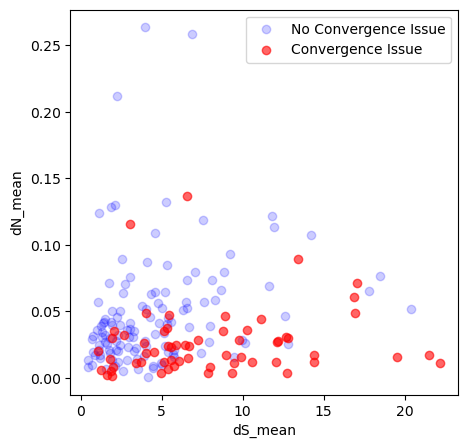

In [114]:
#Visualize dN vs dS with convergence issue flagged

#Plot dN/dS vs mean dS value
fig, ax = plt.subplots(1,1, figsize=(5,5))

#y_values = ['dN_mean', 'dS_mean', 'dN_dS_struct']

#for jj, y_value in enumerate(y_values): 
#ax = axarr[jj]
#xlim = (-0.2,1.2)

y_value =  'dN_mean' #'dN_mean_m0' #'dN_dS_struct_m0' #'dN_mean_m0'#'dN_dS_struct_m0'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dS_mean'# 'Mean(Conservation Rate) [ALL]' # #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_m0_binding_site_found


#dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
#dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = dnds_struct_data[x_value]
y_data = dnds_struct_data[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
#slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
#ax.plot(list(x_data), list(slope*x_data+intercept))
#ax.plot(x_data,x_data)


## Compare M0 between active site and whole protein

In [137]:
#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col = 0 )
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)

dnds_m0_binding_site = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_found.csv'), index_col=0)
m0_binding_site_col_rename = {col : col + '_m0-BS' for col in dnds_m0_binding_site.columns}
dnds_m0_binding_site_for_merge = dnds_m0_binding_site.rename(columns = m0_binding_site_col_rename)

dnds_struct_data = dnds_m0_binding_site_for_merge.merge(dnds_m0_for_merge, how='inner', left_index=True, right_index=True)

In [138]:
feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + binding_site_type) + os.sep

with open(feature_subset_dir + os.sep + 'feature_sizes.pkl', 'rb') as f_in: 
    feature_sizes = pickle.load(f_in)

binding_site_size =[]

for og_ref in dnds_struct_data.index: 
    if og_ref in feature_sizes.keys(): 
        binding_site_size.append(feature_sizes[og_ref])
    else: 
        binding_site_size.append(None)

binding_site_size

dnds_struct_data['BS_size']=binding_site_size

In [139]:
dnds_struct_data.sort_values(by=['dN_dS_struct_m0-BS'], axis = 0, ascending=False)

,og_m0-BS,tree_length_m0-BS,kappa_m0-BS,dN_dS_struct_m0-BS,tree_length_dN_m0-BS,tree_length_dS_m0-BS,convergence_issue_m0-BS,dN_dS_found_m0-BS,dN_mean_m0-BS,dN_std_m0-BS,...,dS>7.5_m0,Mean(Conservation Rate) [ALL]_m0,CV(Type Conservation Rate) [ALL]_m0,Mean(Type Conservation Rate) [ALL]_m0,CV(Conservation Rate) [ALL]_m0,Mean(log2(Abundances)) 10 Sp [EXP]_m0,Median(log2(Abundances)) 10 Sp [EXP]_m0,Std(log2(Abundances)) 10 Sp [EXP]_m0,1k_Mean_log2_Abundances [EXP]_m0,BS_size
OG4312_REF_Scer_AF-P38115-F1-model_v2,OG4312,31.546352,1.48014,0.10729,3.3390,31.1203,False,True,0.123659,0.106018,...,False,0.525630,0.097200,0.682713,0.144966,15.192733,14.613761,1.469610,9.110360,55
OG3313_REF_Scer_AF-P38342-F1-model_v2,OG3313,92.559095,1.93928,0.09536,6.5705,68.9051,False,True,0.211955,0.282893,...,True,0.411345,0.083793,0.601597,0.131049,11.214743,11.214743,2.007136,6.457404,6
OG2061_REF_Scer_AF-Q99258-F1-model_v2,OG2061,121.350833,1.79162,0.06800,5.2636,77.4072,False,True,0.128380,0.339718,...,False,0.637089,0.043867,0.761037,0.099613,14.922156,14.450668,1.469696,8.905814,7
OG2356_REF_Scer_AF-P33312-F1-model_v2,OG2356,288.645047,1.86426,0.06606,11.8684,179.6522,False,True,0.263742,0.515155,...,True,0.521993,0.082753,0.670846,0.122843,14.035608,14.035608,0.171885,NaN,7
OG2906_REF_Scer_AF-P32178-F1-model_v2,OG2906,106.206299,1.09374,0.06063,6.6266,109.2959,False,True,0.129931,0.179180,...,False,0.645487,0.086492,0.755975,0.138334,13.011857,13.119088,0.869737,8.048515,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG3214_REF_Scer_AF-P11986-F1-model_v2,OG3214,437.164501,0.27446,0.00050,0.4981,998.6013,True,True,0.011069,0.015944,...,False,0.698937,0.031221,0.820621,0.049243,19.172579,19.180205,0.349849,13.151980,27
OG1302_REF_Scer_AF-P33401-F1-model_v2,OG1302,400.570913,0.87123,0.00048,0.2058,432.6978,True,True,0.003747,0.006830,...,False,0.686994,0.051137,0.794184,0.074967,15.586996,15.358808,1.569293,6.449244,10
OG1977_REF_Scer_AF-P38066-F1-model_v2,OG1977,187.300684,0.26248,0.00038,0.1761,457.5136,True,True,0.003590,0.007989,...,False,0.720899,0.047670,0.828083,0.073210,13.146469,13.071283,0.696048,NaN,13
OG1813_REF_Scer_AF-P05694-F1-model_v2,OG1813,399.610803,0.55103,0.00028,0.1924,675.2683,True,True,0.003630,0.006901,...,False,0.756699,0.042698,0.834169,0.068704,19.456072,19.429356,0.596394,14.750440,14


In [140]:
#Add dS>3 filter 

dnds_struct_data['dS>3_m0-BS'] = (dnds_struct_data['dS_mean_m0-BS']>3)

In [144]:
dnds_struct_data.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_and_full.csv'))

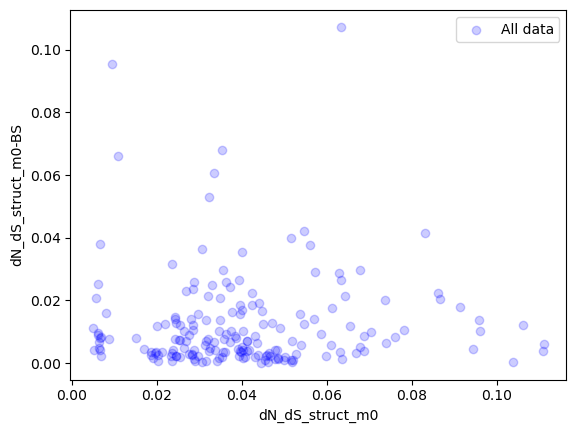

In [142]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' #'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

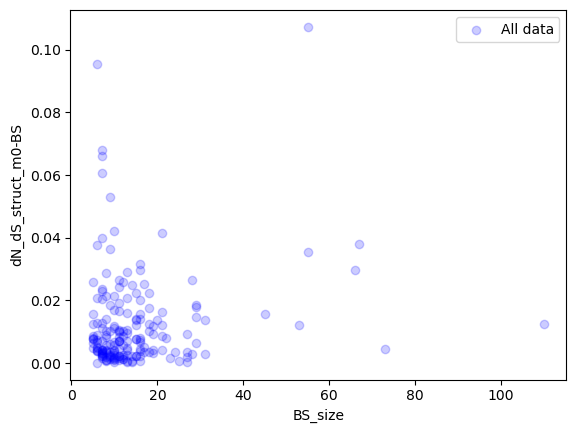

In [121]:
#color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'BS_size'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_background = (dnds_struct_data, 'b',0.2,'All data')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==False], 'b',0.2,'No Convergence Issue')
#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0-BS']==True], 'r',0.6,'Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background]: #, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

In [122]:
#Add in Conservation overall and Conservation of Binding Site

#Extract particular binding sites that look interesting



In [123]:
dnds_struct_data.columns

Index(['og_m0-BS', 'tree_length_m0-BS', 'kappa_m0-BS', 'dN_dS_struct_m0-BS',
       'tree_length_dN_m0-BS', 'tree_length_dS_m0-BS',
       'convergence_issue_m0-BS', 'dN_dS_found_m0-BS', 'dN_mean_m0-BS',
       'dN_std_m0-BS', 'dS_mean_m0-BS', 'dS_std_m0-BS', 'og_m0',
       'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0', 'tree_length_dN_m0',
       'tree_length_dS_m0', 'convergence_issue_m0', 'dN_dS_found_m0',
       'dN_mean_m0', 'dN_std_m0', 'dS_mean_m0', 'dS_std_m0', 'dS>3_m0',
       'dS>5_m0', 'dS>7.5_m0', 'Mean(Conservation Rate) [ALL]_m0',
       'CV(Type Conservation Rate) [ALL]_m0',
       'Mean(Type Conservation Rate) [ALL]_m0',
       'CV(Conservation Rate) [ALL]_m0',
       'Mean(log2(Abundances)) 10 Sp [EXP]_m0',
       'Median(log2(Abundances)) 10 Sp [EXP]_m0',
       'Std(log2(Abundances)) 10 Sp [EXP]_m0',
       '1k_Mean_log2_Abundances [EXP]_m0', 'BS_size', 'dS>3_m0-BS'],
      dtype='object')

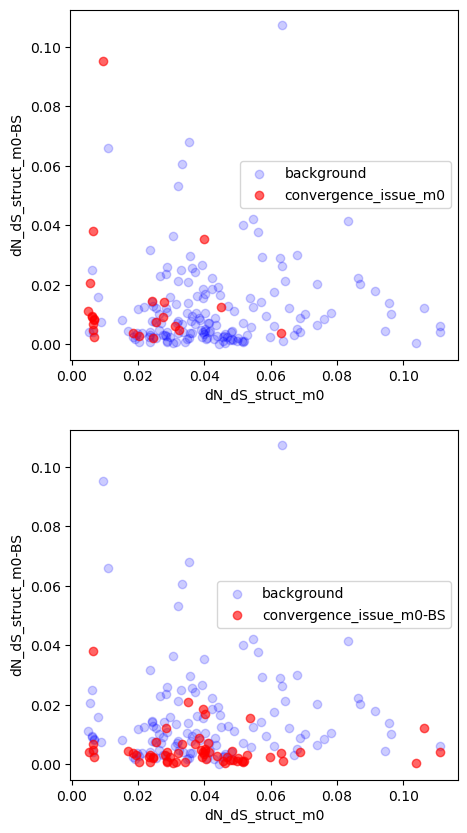

In [124]:
#dN/dS showing convergence issues

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, highlight in enumerate(['convergence_issue_m0', 'convergence_issue_m0-BS']):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data[dnds_struct_data[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data[dnds_struct_data[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [125]:
print('There are ' + str(sum((dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-BS']==False))) + ' ogs which have dN/dS calculated for the binding site and no convergence issues either for the full protein or for the binding site itself')

There are 108 ogs which have dN/dS calculated for the binding site and no convergence issues either for the full protein or for the binding site itself


In [126]:
dnds_struct_data_conv_filt=dnds_struct_data[(dnds_struct_data['convergence_issue_m0']==False) & (dnds_struct_data['convergence_issue_m0-BS']==False)]
dnds_struct_data_conv_filt = dnds_struct_data_conv_filt.copy()

In [127]:
#After filtering out convergence issue, filter out dS > 3 for both

dnds_struct_data_conv_filt['dS>3_m0-BS'] = (dnds_struct_data_conv_filt['dS_mean_m0-BS']>3)

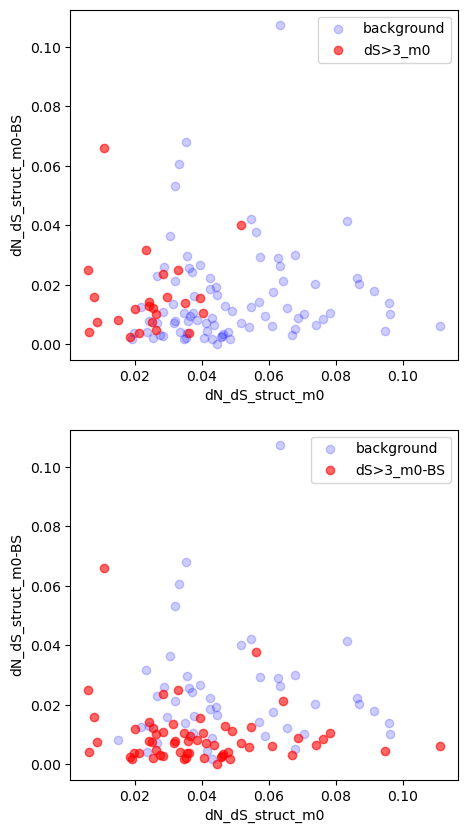

In [128]:
#dN/dS showing dS>3

fig, axarr = plt.subplots(2,1,figsize=(5,10))

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_conv_filt

for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
    ax = axarr[jj]
    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [129]:
print('There are ' + str(sum((dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-BS']==False))) + ' orthogroups with binding sites calculated that have dS<3 for both the binding site and for the entire orthogroup')

There are 42 orthogroups with binding sites calculated that have dS<3 for both the binding site and for the entire orthogroup


In [130]:
dnds_struct_data_ds_filt = dnds_struct_data_conv_filt[(dnds_struct_data_conv_filt['dS>3_m0']==False) & (dnds_struct_data_conv_filt['dS>3_m0-BS']==False)]
dnds_struct_data_ds_filt = dnds_struct_data_ds_filt.copy()

Text(0.02, 0.08, 'R=-0.046\np=0.8')

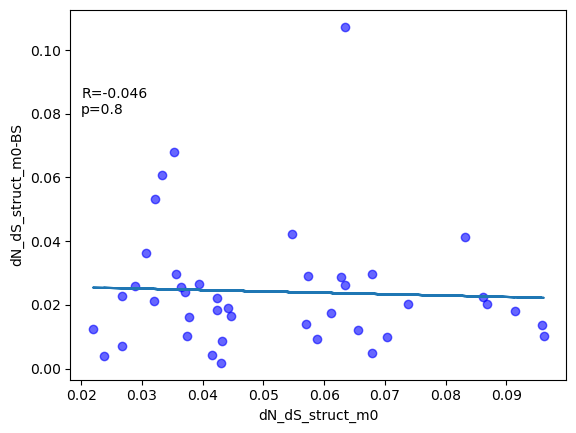

In [131]:
#dN/dS with all filters applied 

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0' # 'tree_length_dS_m0'#'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0-BS' #'tree_length_dS_m0-BS'#'dN_dS_struct_m0-BS' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_struct_data_in = dnds_struct_data_ds_filt

#for jj, highlight in enumerate(['dS>3_m0', 'dS>3_m0-BS']):
#    ax = axarr[jj]
#    dnds_background = (dnds_struct_data_in[dnds_struct_data_in[highlight]==False], 'b',0.2,'background')
#    dnds_foreground = (dnds_struct_data_in[dnds_struct_data_in[highlight]==True], 'r',0.6,highlight)

#(data_to_plot, color, alpha, label) = dnds_background

(data_to_plot, color, alpha, label) = (dnds_struct_data_in, 'b',0.6,'all data')

#good to quantify r2 here
#for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
#ax.legend()

#add linear regression line to scatterplot for background
x_data = data_to_plot[x_value]
y_data = data_to_plot[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.text(0.02, 0.08, 'R={:.2}\np={:.1}'.format(r_value, p_value))

# Look at m0 for Enzymes that have unexpectedly low conservation of Binding site: 

In [134]:
struct_align_cluster_gene_lists_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cluster_gene_lists.json')
with open(struct_align_cluster_gene_lists_fname, 'r') as f:
    struct_align_cluster_gene_lists = json.load(f)
    
#build dictionary from genename to OG_ref

og_ref_lookup_genename = {}

for og_ref, sequence_names in struct_align_cluster_gene_lists.items():
    sc_genes = sequence_names['scer_sequences']['genename']
    for sc_gene in sc_genes: 
        og_ref_lookup_genename[sc_gene] = og_ref
    

In [135]:
low_bsite_cons = {'5A':['QCR6', 'QCR7', 'FAS2', 'SFGH', 'KFA'],    #Filter out RSC6 as it is divided up because of the clustering
            'uniprot': ['PLMT', 'PUT2', 'FAS2', 'GYS1','GYS2','GRE3','YAT2', 'SFGH']
           }

missing_common_names_to_orf = {'SFGH': 'YJL068C', 
                               'GYS1': 'YFR015C', 
                               'GYS2': 'YLR258W', 
                               'KFA': 'YDR428C',  #BNA7
                               'PLMT': 'YJR073C'  #OPI3
                              }
                               
                               

#convert to genename

low_bsite_cons_genename = {}
low_bsite_cons_og_ref = {}
for bsite_cat, common_name_list in low_bsite_cons.items():  
    genename_list = [] 
    og_ref_list = []
    for common_name in common_name_list: 
        if common_name in SC_orfs_lookup.keys(): 
            genename = SC_orfs_lookup[common_name]
        else: 
            genename = missing_common_names_to_orf[common_name]
            print(common_name + ' not in ORF Lookup')
        genename_list.append(genename)
        og_ref_list.append(og_ref_lookup_genename[genename]) 
    
    low_bsite_cons_genename[bsite_cat] = genename_list
    low_bsite_cons_og_ref[bsite_cat] = og_ref_list

#These share SFGH FAS2
#Find 

SFGH not in ORF Lookup
KFA not in ORF Lookup
PLMT not in ORF Lookup
GYS1 not in ORF Lookup
GYS2 not in ORF Lookup
SFGH not in ORF Lookup


In [145]:
dnds_struct_data = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_features/' + binding_site_type + '/m0_binding_site_and_full.csv'), index_col = 0)

In [146]:
set(dnds_struct_data.index) & set(low_bsite_cons_og_ref['uniprot'])

{'OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'OG4391_REF_Scer_AF-P40017-F1-model_v2'}

In [147]:
low_bsite_cons_og_ref['uniprot']

['OG2645_REF_Scer_AF-P05375-F1-model_v2',
 'OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'OG1316_REF_Scer_AF-P19097-F1-model_v2',
 'OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'OG4391_REF_Scer_AF-P40017-F1-model_v2',
 'OG3241_REF_Scer_AF-P40363-F1-model_v2']

In [176]:
goi = 'OG2645_REF_Scer_AF-P05375-F1-model_v2'
struct_align_cluster_gene_lists[goi]

{'all_sequences': ['Calb_AF-A0A1D8PKM5-F1-model_v2',
  'REF_Scer_AF-P05375-F1-model_v2',
  'Spom_AF-O74827-F1-model_v2',
  'alloascoidea_hylecoeti__OG2645__0_4987',
  'ascoidea_rubescens__OG2645__6_4396',
  'candida_apicola__OG2645__13_663',
  'candida_tropicalis__OG2645__30_5327',
  'cyberlindnera_jadinii__OG2645__35_4400',
  'debaryomyces_hansenii__OG2645__36_4456',
  'eremothecium_gossypii__OG2645__40_1907',
  'geotrichum_candidum__OG2645__43_5016',
  'kazachstania_naganishii__OG2645__49_969',
  'kluyveromyces_lactis__OG2645__50_1107',
  'kluyveromyces_marxianus__OG2645__51_3365',
  'komagataella_pastoris__OG2645__52_2659',
  'lachancea_thermotolerans__OG2645__64_3112',
  'lipomyces_starkeyi__OG2645__66_726',
  'ogataea_parapolymorpha__OG2645__104_2289',
  'pachysolen_tannophilus__OG2645__106_3128',
  'tortispora_caseinolytica__OG2645__134_4012',
  'torulaspora_delbrueckii__OG2645__135_1927',
  'vanderwaltozyma_polyspora__OG2645__136_4985',
  'wickerhamomyces_anomalus__OG2645__139_9

In [177]:
feature_sizes[goi]

3

In [170]:
dnds_struct_data.loc[goi]

KeyError: 'OG1022_REF_Scer_AF-P38715-F1-model_v2'

In [63]:
[uniprot_common_name + ': ' + og_ref_lookup_genename[missing_common_names_to_orf[uniprot_common_name]]  for uniprot_common_name in ['PLMT', 'GYS1', 'GYS2']]
#og_ref_lookup_genename[missing_common_names_to_orf['KFA']]  og_ref_lookup_genename[SC_orfs_lookup[gene]]

['PLMT: OG2645_REF_Scer_AF-P05375-F1-model_v2',
 'GYS1: OG1266_REF_Scer_AF-P23337-F1-model_v2',
 'GYS2: OG1266_REF_Scer_AF-P23337-F1-model_v2']

In [64]:
[sc_common_name + ': ' + og_ref_lookup_genename[SC_orfs_lookup[sc_common_name]]  for sc_common_name in ['PUT2','GRE3','YAT2']]

['PUT2: OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'GRE3: OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'YAT2: OG4391_REF_Scer_AF-P40017-F1-model_v2']

Results: 

5A: 

RSC - wierd alignment

Fas2 looks like a normal group - the others have been filtered out. 

DN/dS 0.06745
DN/dS binding site: 0.09599

'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2'  
The thing designated as binding site is very gappy and fails my trimming filter - strict trimming makes it smaller than 0.25 of the average sequence length.  Looks like the binding site is really only there in S. cer.  
'QCR7', 'OG3208_REF_Scer_AF-P00128-F1-model_v2'  Size 3 - filtered out
'SFGH', 'OG3241_REF_Scer_AF-P40363-F1-model_v2'  Size 4 - filtered out 
'KFA', 'OG4463_REF_Scer_AF-Q04066-F1-model_v2'   very high dS


Uniprot: 

FAS2
GYS1: OG1266_REF_Scer_AF-P23337-F1-model_v2,
GYS2: OG1266_REF_Scer_AF-P23337-F1-model_v2

 
Filtered out: 
'SFGH' as above 


'PLMT: OG2645_REF_Scer_AF-P05375-F1-model_v2',
'PUT2: OG1595_REF_Scer_AF-P07275-F1-model_v2',
 'GRE3: OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'YAT2: OG4391_REF_Scer_AF-P40017-F1-model_v2']



In [ ]:
OG4352_REF_Scer_AF-P00127-F1-model_v2 OG3208_REF_Scer_AF-P00128-F1-model_v2 OG3241_REF_Scer_AF-P40363-F1-model_v2 OG4463_REF_Scer_AF-Q04066-F1-model_v2

#Try to run binding site M0 calculation for these four

#If any succeed, try to run it for all


In [ ]:
QCR6

>Calb_AF-A0A1D8PJT8-F1-model_v2.pdb
---------V----T--
>REF_Scer_AF-P00127-F1-model_v2.pdb
EE-LK-TV--VV-A-NE
>Spom_AF-O42932-F1-model_v2.pdb
KF------T----A-SL
>alloascoidea_hylecoeti__OG4352__0_4899.pdb
-V---------------
>ascoidea_rubescens__OG4352__6_2774.pdb
----K------------
>candida_tropicalis__OG4352__30_4463.pdb
-----------------
>cyberlindnera_jadinii__OG4352__35_207.pdb
---YT-LK---------
>debaryomyces_hansenii__OG4352__36_96.pdb
-----------------
>geotrichum_candidum__OG4352__43_1164.pdb
--WTD-VE---------
>komagataella_pastoris__OG4352__52_2977.pdb
-Y--T------------
>lipomyces_starkeyi__OG4352__66_2394.pdb
----I-------E----
>ogataea_parapolymorpha__OG4352__104_3664.pdb
-F--D-----IT-Y---
>pachysolen_tannophilus__OG4352__106_5701.pdb
-----------S-----
>tortispora_caseinolytica__OG4352__134_1986.pdb
-----I-----------
>torulaspora_delbrueckii__OG4352__135_1899.pdb
-----------S-----
>wickerhamomyces_anomalus__OG4352__139_5006.pdb
----A------------
>yHMPu5000034604_sporopachydermia_lactativora_160519__OG4352__170_4168.pdb
-S-LL-TV---------
>yarrowia_lipolytica__OG4352__144_3930.pdb
-----------------
>zygosaccharomyces_rouxii__OG4352__342_4105.pdb
-----------E-----


## Features;  Surface and Core



In [12]:
# Surface / Core: 
# Note that these are only calculated for residues in Olivers alignments that means they are not calculated for residues in 
# a sequence that do not align with the reference sequence. 


#feature='surface'  #core
min_feature_size = 5
#feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

sasa_cut = 0.25

dict_sasa_max = {'ALA': 1.2831596, 'CYS': 1.6075546, 'ASP': 1.6942018, 'GLU': 1.9520556, 'PHE': 2.3931725, 
                     'GLY': 0.9859995, 'HIS': 2.1476686, 'ILE': 1.9781175, 'LYS': 2.4149895, 'LEU': 1.9980704, 
                     'MET': 2.1391654, 'ASN': 1.8180864, 'PRO': 1.6501249, 'GLN': 1.996297, 'ARG': 2.7603362, 
                     'SER': 1.4527341, 'THR': 1.6533911, 'VAL': 1.7248302, 'TRP': 2.773364, 'TYR': 2.5169885,
                     'XYZ': 1.}

surface_core_abbrev = {'core':'C',
                      'surface':'S'
                      }

#Threshold for a column of an alignment to call it "core" (above 0.94 core), "surface" (below 0.06 core) or "unclear"
surface_core_pct_thresholds = (0.2, 0.8) # Should test sensitivity to this parameter. 


In [32]:
# Trim Alignment by Structural Feature

#  Note:  Need to make fasta_renamed and cds_align folders before running this
#  This routine makes alignments (stored in feature_subsets/<feature>/fasta_renamed) and cds alignments (stored in feature_subsets/<feature>/cds_aln) for just the specified feature

#Example OG1316_REF_Scer_AF-P19097-F1-model_v2 -- FAS2 as it is an enzyme with a less conserved binding site
#og_ref = 'OG1316_REF_Scer_AF-P19097-F1-model_v2'

feature_sizes = {'surface':{},
                 'core': {}
                }

surface_core_data = {}

#for fasta_file in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/')):
#og_ref = 'OG1030_REF_Scer_AF-P37291-F1-model_v2'
og_ref = 'OG1694_REF_Scer_AF-P39713-F1-model_v2'
og_ref = fasta_file.split('.')[0]
print(og_ref)

ref = '_'.join(og_ref.split('_')[1:])


#Could add much more to og_surface_core_data and save that


if ref+'.pkl' in os.listdir(summary_data_dir): 
    #Load Summary data for given og_ref
    og_summary_fname = summary_data_dir + os.sep + ref + '.pkl'
    with open(og_summary_fname, 'rb') as f_in:
            og_summary = pickle.load(f_in)

    #Identify Core and Surface Residues for the orthogroup.  
    og_surface_core_data = dyt.extract_surface_core(og_summary, sasa_cut, dict_sasa_max)

    #For untrimmed alignment extract percentage core/surface for each column in the alignment
    # Load Untrimmed Alignment
    aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
    aln = AlignIO.read(open(aln_fname),'fasta')

    core_column_pct_untrimmed, column_occupancy_untrimmed, surface_core_aligned_mat_untrimmed, record_order_untrimmed = dyt.surface_core_analysis_alignment(aln, og_surface_core_data)

    #For each trimmed alignment extract percentage core/surface for each column in the alignment.  
    aln_trim_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trim_strict/' + og_ref + '.tm.fasta.clipkit')

    core_column_pct, column_occupancy, surface_core_aligned_mat, record_order = dyt.surface_core_analysis_untrimmed_to_trimmed(aln_trim_fname,surface_core_aligned_mat_untrimmed)

    #Extract a protein and codon alignment for core and surface
    aln_trimmed = AlignIO.read(open(aln_trim_fname),'fasta')
    aln_trimmed_len = aln_trimmed.get_alignment_length()

    aln_cds_fname_short = og_ref + '.tm.fasta.clipkit.cds'
    if aln_cds_fname_short in os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_trim_strict/')):
                                            
        aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_trim_strict/' + aln_cds_fname_short)
        
        aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')

        og_surface_core_data['trimmed_alignment'] = {}

        #Based on trimmed alignment threshold choose Core / Surface part of protein

        surface_core_discrete = []
        for col_core_pct in core_column_pct:
            if col_core_pct<surface_core_pct_thresholds[0]:
                surface_core_discrete.append('S')
            elif col_core_pct>surface_core_pct_thresholds[1]:
                surface_core_discrete.append('C')
            else: 
                surface_core_discrete.append('N')

        #Quantify amount of core, surface and neither
        og_surface_core_count = Counter(surface_core_discrete)

        og_surface_core_data['trimmed_alignment']['pct_core'] = og_surface_core_count['C']/aln_trimmed_len
        og_surface_core_data['trimmed_alignment']['pct_surface'] = og_surface_core_count['S']/aln_trimmed_len
        og_surface_core_data['trimmed_alignment']['pct_unclear'] = og_surface_core_count['N']/aln_trimmed_len


        #Could also compare this to Oliver's based only on the ref. 

        #Extract a protein and codon alignment for core and surface and save

        #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
        #Converts alignment to numpy array then converts back to aln object

        for feature in ['surface','core']: 
            feature_subset_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/feature_subsets/' + feature) + os.sep

            feature_inds = [jj for jj,col_status in enumerate(surface_core_discrete) if col_status==surface_core_abbrev[feature]]

            aln_temp = aln_trimmed[:,0:0]
            aln_cds_temp = aln_cds[:,0:0]

            for x in feature_inds:
                aln_subset = aln_temp[:,:] + aln_trimmed[:, (x-1):x]
                aln_temp = aln_subset

                aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
                aln_cds_temp = aln_cds_subset

            #Save alignment subset
            aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
            with open(aln_subset_fname_out,'w') as f_out: 
                for record in aln_subset:
                    f_out.write('>' + record.id + '\n')   # Could add a length to this
                    f_out.write(str(record.seq) + '\n')

            aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
            with open(aln_cds_subset_fname_out,'w') as f_out: 
                for record in aln_cds_subset:
                    f_out.write('>' + record.id + '\n')   # Could add a length to this
                    f_out.write(str(record.seq) + '\n')

            feature_sizes[feature][og_ref] = aln_subset.get_alignment_length()

        surface_core_data[og_ref] = og_surface_core_data
    else: 
        print(og_ref + ' does not have trimmed codon alignment.  May not have minimum structure/sequence filter')


OG1694_REF_Scer_AF-P39713-F1-model_v2


KeyError: 'C'

In [31]:
jupyter.debugJustMyCode

NameError: name 'jupyter' is not defined

In [21]:
og_ref = 'OG1306_REF_Scer_AF-P38298-F1-model_v2'  #'OG2290_torulaspora_delbrueckii__OG2290__135_3975'


False

In [269]:
aln[:,492]

'-----------------------------------------------------'

In [266]:
og_surface_core_data['protein_data']['REF_Scer_AF-P37291-F1-model_v2']['full_protein_assignment'][67]

'C'

In [240]:
aln_cds_subset

<<class 'Bio.Align.MultipleSeqAlignment'> instance (26 records of length 2448) at 1a1dfb89010>

In [239]:
aln_subset

<<class 'Bio.Align.MultipleSeqAlignment'> instance (26 records of length 816) at 1a1d9e6cf10>

In [276]:
def surface_core_analysis_untrimmed_to_trimmed(aln_trim_fname,surface_core_aligned_mat_untrimmed):
    zerocolumns = False
    aln_trimmed = AlignIO.read(open(aln_trim_fname),'fasta')
    
    #Load clipkit log
    aln_trim_log_fname = aln_trim_fname + '.log'
    aln_trim = AlignIO.read(open(aln_trim_fname),'fasta')
    
    record_order = []
    for record in aln_trim:
        record_order.append(record.id)
        
    aln_trim_log = pd.read_table(aln_trim_log_fname, sep=' ', header=None, index_col=0)
    aln_trim_log.rename(columns={1:'trim',2:'note',3:'value'}, inplace=True)

    #makes a zero-based list of indices of the original full alignment index for extracting the trimmed index
    #trim_ind_2_orig_ind = {}
    aln_trim_log_kept = aln_trim_log[aln_trim_log['trim']=='keep']
    aln_trim_log_kept_list = []
    for trim_ind, orig_ind in enumerate(aln_trim_log_kept.index): 
        aln_trim_log_kept_list.append(orig_ind-1)
        #trim_ind_2_orig_ind[trim_ind+1] = orig_ind

    surface_core_aligned_mat = surface_core_aligned_mat_untrimmed[:,aln_trim_log_kept_list]
    
    core_column_pct = [] #Surface column pct will be 1-core column pct
    column_occupancy = []
    nspecs = surface_core_aligned_mat.shape[0]
    for jj in range(surface_core_aligned_mat.shape[1]): 
        col = surface_core_aligned_mat[:,jj]
        col_count = Counter(col)
        if (col_count['C']+col_count['S'])==0: 
            zerocolumns = True  
            core_column_pct.append(np.nan)
        else: 
            core_column_pct.append(col_count['C']/(col_count['C']+col_count['S']))
        column_occupancy.append((nspecs-col_count['-'])/nspecs)
    
    if zerocolumns: 
        print('at least one trimmed alignment column has no surface or core residues - may be empty')
        
    return core_column_pct, column_occupancy, surface_core_aligned_mat, record_order

In [264]:
seq_out, msa2input, input2msa, pair_mapping = dyt.seq_squeeze(aln[2].seq)

In [275]:
def surface_core_analysis_alignment(aln, og_surface_core_data):
    #Given an untrimmed alignment, extracts the percentage of residues that are core, and the percentage of columns of the alignment that are occupied, and the full matrix with "I", "O", or "-" in each column.  
    #Also provides the order of the proteins from the alignment which may not be the same as in the core/surface data
    zerocolumns = False
    
    surface_core_aligned = []
    record_order = []
    for record in aln:
        record_order.append(record.id)
        seq_out, msa2input, input2msa, pair_mapping = dyt.seq_squeeze(record.seq)

        surface_core_unaligned_prot = og_surface_core_data['protein_data'][record.id.split('.')[0]]['full_protein_assignment']

        surface_core_aligned_prot = []

        for jj, res in enumerate(record.seq): 
            if res=='-': 
                surface_core_aligned_prot.append('-')
            else: 
                surface_core_aligned_prot.append(surface_core_unaligned_prot[msa2input[jj]])

        surface_core_aligned.append(surface_core_aligned_prot)

    surface_core_aligned_mat = np.array(surface_core_aligned)

    core_column_pct = [] #Surface column pct will be 1-core column pct
    column_occupancy = []
    nspecs = surface_core_aligned_mat.shape[0]
    for jj in range(surface_core_aligned_mat.shape[1]): 
        col = surface_core_aligned_mat[:,jj]
        col_count = Counter(col)
        if (col_count['C']+col_count['S'])==0: 
            zerocolumns=True
            core_column_pct.append(np.nan)
        else: 
            core_column_pct.append(col_count['C']/(col_count['C']+col_count['S']))
        column_occupancy.append((nspecs-col_count['-'])/nspecs)
    
    if zerocolumns: 
        print('alignment column has no surface or core residues - may be empty') 
    
    return core_column_pct, column_occupancy, surface_core_aligned_mat, record_order

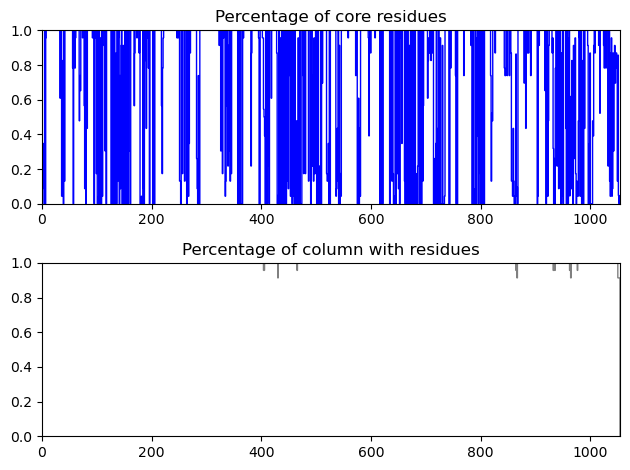

In [246]:
#Example analysis of core column percentage and column occupancy for untrimmed alignment. 

fig, axarr = plt.subplots(2,1)
ind_range = (0,len(core_column_pct))#(1000,1100)#(0,120)
ylim = (0,1)
xlim = (0,len(core_column_pct))

ax0 = axarr[0]
ax0.stairs(core_column_pct[ind_range[0]:ind_range[1]], color='blue')
ax0.set_ylim(ylim)
ax0.set_xlim(xlim)
ax0.set_title("Percentage of core residues")

ax1 = axarr[1]
ax1.stairs(column_occupancy[ind_range[0]:ind_range[1]], color='grey')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title("Percentage of column with residues")

fig.tight_layout()


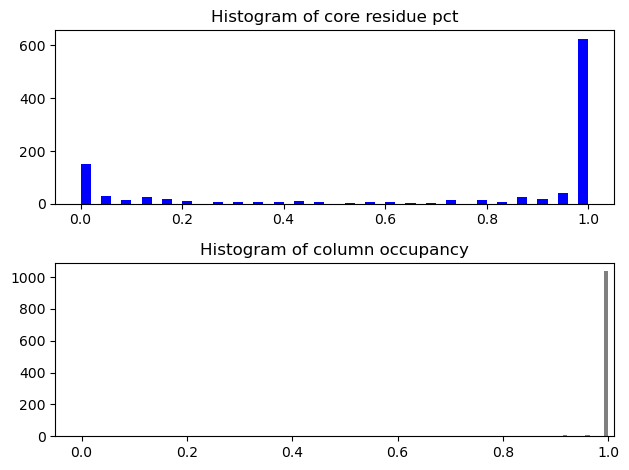

In [247]:
fig, axarr = plt.subplots(2,1)

ax0 = axarr[0]
ax0.hist(core_column_pct, color='blue', bins=50)
#ax0.set_ylim(ylim)
#ax0.set_xlim(xlim)
ax0.set_title("Histogram of core residue pct")

ax1 = axarr[1]
ax1.hist(column_occupancy, color='grey')
#ax1.set_ylim(ylim)
ax1.set_xlim((-0.05,1.01))
ax1.set_title("Histogram of column occupancy")

fig.tight_layout()

Text(0, 0.5, 'Column occupancy')

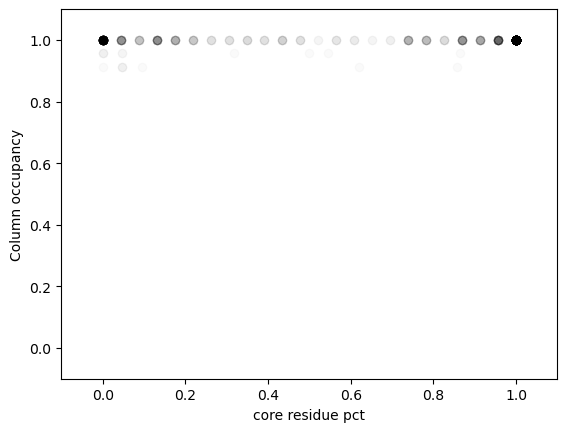

In [248]:
fig, ax = plt.subplots(1,1)

ax.scatter(core_column_pct, column_occupancy, color='black', alpha=0.02)
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-0.1,1.1)
#ax0.set_xlim(xlim)
ax.set_xlabel("core residue pct")
ax.set_ylabel("Column occupancy")

#fig.tight_layout()

In [230]:
def extract_surface_core(og_summary, sasa_cut, dict_sasa_max):
    #For a given protein lists how many are Core, Surface, Missing From Alignment, Not assigned 
    #Would be good to check Oliver's alignment vs my alignment to make sure it is correct.  
    #This should be something saved somewhere as a reference

    og_surface_core_data = {}
    og_surface_core_data['protein_data']={}

    for prot_ind, prot_name in enumerate(og_summary['Molecules'].keys()): 
        #prot_name = 'yHMPu5000034957_hanseniaspora_osmophila_160519__OG1316__247_2096'
        #prot_ind = prot_ind_lookup[prot_name]
        mol_sasa = og_summary['Molecules'][prot_name]['SASA']
        mol_res = og_summary['Molecules'][prot_name]['Residues']

        core_res_all = (mol_sasa/np.vectorize(dict_sasa_max.get)(mol_res))<sasa_cut
        surface_res_all = (mol_sasa/np.vectorize(dict_sasa_max.get)(mol_res))>sasa_cut

        #Initialize surface_core, a vector that indicates whether a residue in the sequence is, core, surface, or NA if not calculated 
        surface_core = ['NA']*len(mol_res)

        #surface_residues: 
        for jj, surface_bool in enumerate(surface_res_all): 
            if surface_bool: 
                #seq_ind = mapping_ref_based_aln[jj]
                surface_core[jj]= 'S'

        #core_residues: 
        for jj, core_bool in enumerate(core_res_all): 
            if core_bool: 
                #seq_ind = mapping_ref_based_aln[jj]
                surface_core[jj]= 'C'

        surface_core_count = Counter(surface_core)

        #Check that all residues for the protein in the ref_based alignment are assigned to either core or surface. 
        assert len(mol_res) == (surface_core_count['S'] + surface_core_count['C']), 'Residue aligned to reference structure not assigned as core or surface'

        
        surface_core_pct = {}
        for key, count in surface_core_count.items():
            surface_core_pct[key] = count/len(mol_res)

        og_surface_core_data['protein_data'][prot_name] = {'full_protein_assignment' : surface_core,
                                          'full_protein_count': {'core': surface_core_count['C'], 'surface': surface_core_count['S']}, 
                                          'full_protein_pct' :  {'core': surface_core_pct['C'], 'surface': surface_core_pct['S']}
                                         }

    cores = []
    surfaces = []

    for key, data in og_surface_core_data['protein_data'].items(): 
        #print(key)
        cores.append(data['full_protein_pct']['core'])
        surfaces.append(data['full_protein_pct']['surface'])

    og_surface_core_data['core_mean'] = np.mean(cores)
    og_surface_core_data['core_std'] = np.std(cores)
        
    return og_surface_core_data



In [ ]:
    
    
#         #Check to see if the feature exists for that protein
#         if 'Binding Site' in set(og_summary['Mapping Colors'].keys()):

#             aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
#             aln = AlignIO.read(open(aln_fname),'fasta')

#             aln_cds_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_aln/' + og_ref + '.tm.cds.aln.fasta')
#             aln_cds = AlignIO.read(open(aln_cds_fname),'fasta')


#             #Load alignment and make dictionary to map ref structure coordinates to alignment coordinates

#             ref_ind=None
#             for (jj, record) in enumerate(aln): 
#                 if ref == record.id.split('.')[0]:
#                     ref_ind = jj

#             #Get map for reference sequence from msa index
#             ref_seq_from_msa = str(aln[ref_ind,:].seq)
#             ref_seq, msa2ref, ref2msa, pair_mapping = dyt.seq_squeeze(ref_seq_from_msa)


#             #Get list of indices for the feature   
#             feat_inds_ref = []
#             for jj, feature_present in enumerate((og_summary['Mapping Colors']['Binding Site']==1)): 
#                 if feature_present:
#                     feat_inds_ref.append(jj)

#             feature_size = len(feat_inds_ref)
#             feature_sizes[og_ref] = feature_size

#             if feature_size>= min_feature_size: 
#                 feat_inds_msa = []


#                 for feat_ind in feat_inds_ref: 
#                     feat_inds_msa.append(ref2msa[feat_ind])

#                     #Verify seq_squeeze is mapping correctly
#                     assert (ref_seq[feat_ind] == ref_seq_from_msa[ref2msa[feat_ind]]), "bad mapping to ref from seq_squeeze"

#                     #Verify identical sequence in tm_align reference and in Output/Summary data
#                     aa_3L_caps = og_summary['Mapping']['Amino Acid'][0,:][feat_ind]
#                     aa_3L = aa_3L_caps[0] + aa_3L_caps[1:].lower()
#                     trans_dict[aa_3L]
#                     assert (ref_seq[feat_ind] == trans_dict[aa_3L]), "Difference in sequence between tm_align alignment and Output/Summary data: " + og_ref + ' ' + str(feat_ind) + ' ' + ref_seq[feat_ind] + ' vs ' + aa3L 

#                 #Extract Alignment Subsets
#                 #A more efficient way of doing this is here: https://www.biostars.org/p/460408/
#                 #Converts alignment to numpy array then converts back to aln object

#                 aln_temp = aln[:,0:0]
#                 aln_cds_temp = aln_cds[:,0:0]

#                 for x in feat_inds_msa:
#                     aln_subset = aln_temp[:,:] + aln[:, (x-1):x]
#                     aln_temp = aln_subset

#                     aln_cds_subset = aln_cds_temp[:,:] + aln_cds[:, (3*(x-1)):(3*x)]
#                     aln_cds_temp = aln_cds_subset

#                 #Save alignment subset
#                 aln_subset_fname_out = feature_subset_dir + os.path.normpath('fasta_renamed/' + og_ref + '.tm.fasta')
#                 with open(aln_subset_fname_out,'w') as f_out: 
#                     for record in aln_subset:
#                         f_out.write('>' + record.id + '\n')   # Could add a length to this
#                         f_out.write(str(record.seq) + '\n')

#                 aln_cds_subset_fname_out = feature_subset_dir + os.path.normpath('cds_aln/' + og_ref + '.tm.cds.aln.fasta')
#                 with open(aln_cds_subset_fname_out,'w') as f_out: 
#                     for record in aln_cds_subset:
#                         f_out.write('>' + record.id + '\n')   # Could add a length to this
#                         f_out.write(str(record.seq) + '\n')
#             else: 
#                 print(feature + ' size of ' + str(feature_size) + ' below threshold size of ' + str(min_feature_size))

#         else: 
#             print('No ' + feature + ' for ' + og_ref)
    
#     else: 
#         print('No .pkl file for ' + og_ref)

In [ ]:
# #Protein sequence: 
# og_prot_unaligned_fname = os.path.normpath(base_dir + '/selected_proteins/og_sequences/proteome_tm/' + og_ref + '.pep.fasta')

# og_prot_unaligned = {}
# for record in SeqIO.parse(og_prot_unaligned_fname, "fasta"):
#         og_prot_unaligned[record.id] = record.seq

# #From Reference Based Alignment


In [7]:
#og_inner_outer_data['vanderwaltozyma_polyspora__OG1316__136_1009']['full_protein_assignment']

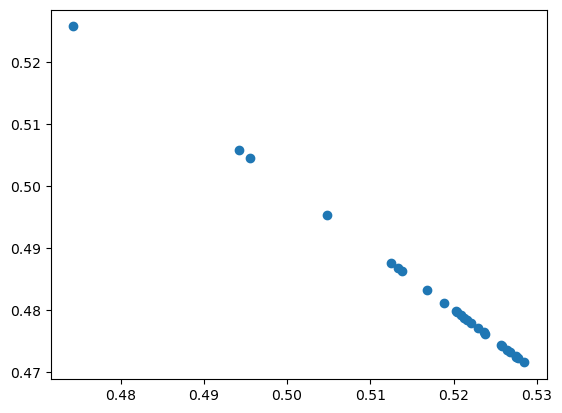

In [18]:
#Plot percentage inner and outer for a given OG.  Calculate averages and std. 

fig, ax = plt.subplots(1,1)

inners = []
outers = []

for key, data in og_inner_outer_data.items(): 
    #print(key)
    inners.append(data['full_protein_pct']['inner'])
    outers.append(data['full_protein_pct']['outer'])
    
ax.scatter(inners, outers)

np.std(inners)


0.012437847603155932

In [ ]:
inner_res = ((data_dict["SASA"]/np.vectorize(dict_sasa_max.get)(data_dict["Amino Acid"])) < sasa_cut) & (data_dict["SASA"] != -1)
outer_res = ((data_dict["SASA"]/np.vectorize(dict_sasa_max.get)(data_dict["Amino Acid"])) >= sasa_cut) & (data_dict["SASA"] != -1)

In [10]:
len(og_inner_outer_data[prot_name]['full_protein_assignment'])

1577

In [26]:
a = og_inner_outer_data[prot_name]['full_protein_assignment']

In [27]:
a[85]

'outer'

In [28]:
outer_res_all[85]

True

In [11]:
len(og_summary['Molecules']['yHMPu5000034957_hanseniaspora_osmophila_160519__OG1316__247_2096']['SASA'])

1577

In [29]:
for jj, (oliver, inner, outer) in enumerate(zip(og_inner_outer_data[prot_name]['full_protein_assignment'], inner_res_all, outer_res_all )):
    if oliver != 'NA': 
        if oliver=='inner':
            if inner != True: 
                print(jj)
        elif oliver == 'outer': 
            if outer != True: 
                print(jj)
            

In [20]:
sum(inner_res_all)


748

In [21]:
sum(outer_res_all)

829

In [ ]:
og_summary['Molecules']['yHMPu5000034957_hanseniaspora_osmophila_160519__OG1316__247_2096']['SASA']

In [87]:
inner_outer_count['outer'] + inner_outer_count['inner']

898

In [56]:
prot_ind_lookup

{'REF_Scer_AF-P19097-F1-model_v2': 0,
 'Calb_AF-A0A1D8PK65-F1-model_v2': 1,
 'Spom_AF-Q10289-F1-model_v2': 2,
 'alloascoidea_hylecoeti__OG1316__0_7309': 3,
 'ascoidea_rubescens__OG1316__6_2952': 4,
 'candida_apicola__OG1316__13_3208': 5,
 'candida_tropicalis__OG1316__30_3680': 6,
 'debaryomyces_hansenii__OG1316__36_4062': 7,
 'eremothecium_gossypii__OG1316__40_3799': 8,
 'geotrichum_candidum__OG1316__43_5811': 9,
 'geotrichum_candidum__OG1316__43_5871': 10,
 'kluyveromyces_lactis__OG1316__50_2356': 11,
 'kluyveromyces_marxianus__OG1316__51_2665': 12,
 'komagataella_pastoris__OG1316__52_2577': 13,
 'lachancea_thermotolerans__OG1316__64_2372': 14,
 'lachancea_thermotolerans__OG1316__64_48': 15,
 'lipomyces_starkeyi__OG1316__66_1600': 16,
 'lipomyces_starkeyi__OG1316__66_5841': 17,
 'ogataea_parapolymorpha__OG1316__104_2685': 18,
 'pachysolen_tannophilus__OG1316__106_2759': 19,
 'tortispora_caseinolytica__OG1316__134_385': 20,
 'torulaspora_delbrueckii__OG1316__135_1867': 21,
 'vanderwalt

In [18]:
og_summary['Mapping'].keys()

dict_keys(['Mapping', 'Mapping distance', 'Keys', 'Amino Acid', 'Amino Acid Type', 'pLDDT', 'DSSP', 'SASA'])

In [48]:
[-200:-1]

array([1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456,
       1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465,   -1,   -1,
       1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476,
       1477, 1478, 1479, 1480, 1481,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1, 1574,   -1,   -1,   -1, 1573,   -1,   -1,   -1,
         -1,   -1, 1559,   -1, 1544,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   

In [34]:
a = og_summary['Mapping']['Amino Acid'][0]
for aa in a: 
    if aa == 'XYZ': 
        print(aa)

In [14]:
Counter(outer_res[0])[True]

952

In [43]:
dict_sasa_max.get

<function dict.get(key, default=None, /)>

In [38]:
#list(list((data_dict["SASA"]/np.vectorize(dict_sasa_max.get)(data_dict["Amino Acid"]))[1]))
data_dict['SASA']
np.vectorize(dict_sasa_max.get)(data_dict["Amino Acid"])
data_dict["Amino Acid"]

array([['MET', 'LYS', 'PRO', ..., 'THR', 'LYS', 'LYS'],
       ['XYZ', 'XYZ', 'XYZ', ..., 'XYZ', 'XYZ', 'XYZ'],
       ['XYZ', 'XYZ', 'XYZ', ..., 'XYZ', 'XYZ', 'XYZ'],
       ...,
       ['XYZ', 'XYZ', 'XYZ', ..., 'XYZ', 'XYZ', 'XYZ'],
       ['XYZ', 'XYZ', 'XYZ', ..., 'XYZ', 'XYZ', 'XYZ'],
       ['XYZ', 'XYZ', 'XYZ', ..., 'XYZ', 'XYZ', 'XYZ']], dtype='<U25')

In [11]:
data_dict["SASA"]

array([[ 2.00551414,  1.29303646,  0.97706592, ...,  0.62784964,
         0.98011053,  2.25241661],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [10]:
#Older version going from Olivers

#For a given protein lists how many are Inner, Outer, Missing From Alignment, Not assigned 
#Would be good to check Oliver's alignment vs my alignment to make sure it is correct.  
#This should be something saved somewhere as a reference


og_inner_outer_data = {}



#Protein sequence: 
og_prot_unaligned_fname = os.path.normpath(base_dir + '/selected_proteins/og_sequences/proteome_tm/' + og_ref + '.pep.fasta')

og_prot_unaligned = {}
for record in SeqIO.parse(og_prot_unaligned_fname, "fasta"):
        og_prot_unaligned[record.id] = record.seq

#From Reference Based Alignment


for prot_ind, prot_name in enumerate(og_summary['Molecules'].keys()): 
    #prot_name = 'yHMPu5000034957_hanseniaspora_osmophila_160519__OG1316__247_2096'
    #prot_ind = prot_ind_lookup[prot_name]
    mapping_ref_based_aln = og_summary['Mapping']['Mapping'][prot_ind]

    prot_seq = og_prot_unaligned[prot_name + '.pdb']

    #Initialize inner_outer, a vector that indicates whether a residue in the sequence is, core, surface, or NA if not calculated 
    inner_outer = ['NA']*len(prot_seq)

    #outer_residues: 
    for jj, outer_bool in enumerate(outer_res[prot_ind]): 
        if outer_bool: 
            seq_ind = mapping_ref_based_aln[jj]
            inner_outer[seq_ind]= 'outer'

    #inner_residues: 
    for jj, inner_bool in enumerate(inner_res[prot_ind]): 
        if inner_bool: 
            seq_ind = mapping_ref_based_aln[jj]
            inner_outer[seq_ind]= 'inner'

    inner_outer_count = Counter(inner_outer)

    #Check that all residues for the protein in the ref_based alignment are assigned to either core or surface. 
    assert len([item for item in mapping_ref_based_aln if item != -1])== (inner_outer_count['outer'] + inner_outer_count['inner']), 'Residue aligned to reference structure not assigned as inner or outer'

    inner_outer_pct = {}
    for key, count in inner_outer_count.items():
        inner_outer_pct[key] = count/len(prot_seq)

    og_inner_outer_data[prot_name] = {'full_protein_assignment' : inner_outer,
                                      'full_protein_count': dict(inner_outer_count), 
                                      'full_protein_pct' : inner_outer_pct,
                                      'ref_alignment_index' : prot_ind
                                     }


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])